# Get all the imports necessary

In [1]:
# using GuSTO
include("../src/GuSTO.jl")
using AstrobeeRobot
using Plots
using JLD2, FileIO
using Plots
using BenchmarkTools
using Statistics
using HDF5
using Keras
import Plots.Animation

┌ Info: Precompiling BulletCollision [b3564421-7037-56b3-90f4-5b7f54e2ead3]
└ @ Base loading.jl:1192


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/75259c676c4c94b02ca26a89265c53e5a244a54a-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/75259c676c4c94b02ca26a89265c53e5a244a54a-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

# Only Freeflyer models to be used

In [2]:
robot = Freeflyer()
model = FreeflyerSE2()


FreeflyerSE2(6, 3, 0.05, Any[], Any[], Any[])

# Carry out sequence with shooting

In [3]:
function carryOutSequence(runs, NNDualParams = nothing, NNDualJSON = nothing, NNDualWeights = nothing)
    println("----------")
#     env = setUpEnvironmentNoObstacle()
#     env = setUpEnvironmentOneObstacle()
    env = setUpEnvironmentTwoObstacle()
    N = 20
    x_goal = [3.; 0.5; 0; 0; 0; 0]
#     x_init = [0.01; 2.3; 0; 0; 0; 0]
#     x_init = [2.0; 2.5; 0; 0; 0; 0]
    x_init = [0.2; 2.3; 0; 0; 0; 0] #- used this one for one slide
#     x_init = [0.2; 0.8; 0; 0; 0; 0] 
#     x_init = [2.0; 0.8; 0; 0; 0; 0] 
#     x_init = [1.5; 0.8; 0; 0; 0; 0]
    
    tf = 80
    ω0 = 1.0 
    Δ0 = 3.0
    
    time_start = time_ns()
    TOP = []
    TOSgusto = []
    TOP, TOSgusto = setUpProblemAllParams(N, x_init, x_goal, robot, model, env, tf_guess = 200.)
#     TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = tf);    
    traj_init = init_traj_straightline(TOP)
    if !isdefined(TOSgusto, :SCPS)
        SCPP = SCPProblem(TOP)
        SCPS = SCPSolution(SCPP, traj_init)
        TOSgusto.traj, TOSgusto.SCPS = SCPS.traj, SCPS
    end
    
    gusto_setup_time = (time_ns() - time_start)/10^9

    dual_init = zeros(6);
    dual_vec = [dual_init]
    TOSgusto.SCPS.dual = dual_vec[end]

    traj_init_X = traj_init.X
    traj_init_U = traj_init.U

    traj_X_vec = [traj_init_X]
    traj_U_vec = [traj_init_U]
    
    times = []
    
    time_start = time_ns()
    # Set up NN if required
    if !(NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(NNDualParams)
        NN = Keras.load(NNDualJSON, NNDualWeights)
    end
    NN_setup_time = (time_ns() - time_start)/10^9
    
    
    # Set up shooting problem
    N = 20
    SP = ShootingProblem(TOP, TOSgusto.SCPS)
    TOSgusto.SS = ShootingSolution(SP, deepcopy(traj_init))
    SS = TOSgusto.SS
    
    println("GuSTO setup time is $gusto_setup_time")
    println("NN setup time is $NN_setup_time")
    
    while length(runs)>0
        run = popfirst!(runs)
        if startswith(run,"GuSTO-")
            num_iter = parse(Int64, run[7:end])
            println("Doing $num_iter iteration(s) of GuSTO")
            traj = Trajectory(traj_X_vec[end], traj_U_vec[end], tf)
            # Set dual to the end of dual_vec
            if !isdefined(TOSgusto, :SCPS)
                println("defining SCPS")
                SCPP = SCPProblem(TOP)
                SCPS = SCPSolution(SCPP, traj)
                TOSgusto.traj, TOSgusto.SCPS = SCPS.traj, SCPS
            end
            TOSgusto.traj = traj
            TOSgusto.SCPS.dual = dual_vec[end]
            solve_gusto_jump!(TOSgusto.SCPS, TOSgusto.SCPS.SCPP, "Ipopt", max_iter=num_iter, print_level=1)

#             solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj, "Ipopt", max_iter=num_iter, print_level=1);
            iter_times = TOSgusto.SCPS.iter_elapsed_times
            @show iter_times
            @show TOSgusto.SCPS.J_true
            num_actual_iter = (length(iter_times)>num_iter+1) ? num_iter : length(iter_times)-1
            append!(times, iter_times[end-(num_actual_iter-1):end])
            push!(dual_vec, TOSgusto.SCPS.dual)
            push!(traj_X_vec, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec, TOSgusto.SCPS.traj.U)
            if (TOSgusto.SCPS.converged)
                println("GuSTO converged!")
                println("Cost reported: $(TOSgusto.SCPS.J_true)")
            end
        elseif startswith(run,"NNDual-")
            num_iter = parse(Int64, run[8:end])
            if (NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
                println("Error: one or more of the NN duals filenames is missing")
            else
                println("Doing $num_iter iteration(s) of NN- dual")
                if isdefined(TOSgusto, :SCPS) && isdefined(TOSgusto.SCPS, :param) && isdefined(TOSgusto.SCPS.param, :alg)
                    ω = TOSgusto.SCPS.param.alg.ω_vec[end]
                    Δ = TOSgusto.SCPS.param.alg.Δ_vec[end]
                else 
                    ω = ω0
                    Δ = Δ0
                end
                NN_input = createNNInput(traj_X_vec[end], traj_U_vec[end], ω, Δ, xMin, xRange, dual_vec[end])
                NN_inter = NN_input
                for i=1:num_iter
                    time_start = time_ns()
                    
                    NN_output = NN(NN_inter)
                    output_dual = recoverDualfromNNOutput(NN_output, yMin, yRange)
                    
                    iter_elapsed_time = (time_ns() - time_start)/10^9
                    push!(times, iter_elapsed_time)
                    
                    push!(dual_vec, output_dual)
                    
                    # Just repeating the same trajectories
                    push!(traj_X_vec, traj_X_vec[end])
                    push!(traj_U_vec, traj_U_vec[end])
                    
                    # output dual is input for next iteration of NN
                    NN_inter = vcat(NN_input[1:182], output_dual)
                end
            end
        elseif startswith(run, "Shooting")
            TOSgusto.SS.SP.p0 = dual_vec[end]
            solve!(TOSgusto.SS, TOSgusto.SS.SP)
            push!(times, TOSgusto.SS.iter_elapsed_times[end])
            if TOSgusto.SS.prob_status[end]== Symbol(:Optimal)
                println("Shooting method converged!")
                println("Costs reported: $(TOSgusto.SS.J_true)")
            else
                println("Shooting method did not converge.")
            end
        else
            println("Error: $run is not a supported command. Make sure to append the number of iterations at the end of a command.")
        end
    end
    @show times
    # @show dual_vec
    println("----------")
    return (dual_vec, traj_X_vec, traj_U_vec, times)
end

carryOutSequence (generic function with 4 methods)

## Two obstacles

In [4]:
env = setUpEnvironmentTwoObstacle()
paramsFileName = "TwoObstacleDualParams.h5"
jsonFileName = "TwoObstacleWithDuals.json"
weightsFileName = "TwoObstacleWithDualsWeights.h5"
# runs = ["GuSTO-100"]
# runs = ["GuSTO-100","Shooting"]
# (dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)

runs = ["GuSTO-100"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
@show dual_vec
# @show length(times)
# @show sum(times)

# [1.00237, -0.000229532, 0.0, 0.237358, -0.0254306, 0.0]

# runs = ["GuSTO-1", "Shooting"]
# (dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
# @show length(times)
# @show sum(times)
# @show dual_vec
# # # Shooting converged 

# # runs = ["Shooting"]
# # (dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
# # @show dual_vec

# # runs = ["NNDual-1"]
# # (dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
# # @show dual_vec
# # # [-0.00160321, 4.58636e-5, 0.0, 0.236086, -0.0130076, 0.0]

runs = ["NNDual-1", "Shooting"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
# @show length(times)
# @show sum(times)
@show dual_vec

# runs = ["GuSTO-20","NNDual-1", "Shooting"]
# (dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
# @show dual_vec

carryOutSequence(["NNDual-1", "GuSTO-3", "Shooting", "GuSTO-1"])

UndefVarError: UndefVarError: setUpEnvironmentTwoObstacle not defined

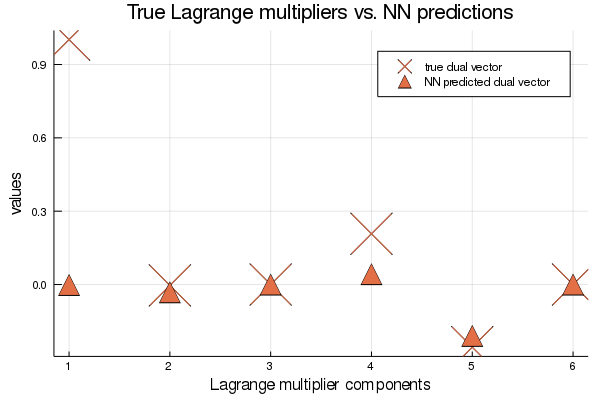

In [5]:
true_dual_vec = [[0.000847697, -0.000254295, 0.0, 0.0847697, -0.0254301, 0.0],[0.000847697, -0.00169567, 0.0, 0.0847697, -0.169543, 0.0],[1.00173, -0.00364827, 0.0, 0.207705, -0.256306, 0.0]]
NN_dual_vec = [[-0.00160318, -0.03164, 0.0, 0.0423849, -0.0300981, 0.0], [-0.00160318, -0.03164, 0.0, 0.0423849, -0.168441, 0.0],[-0.00160318, -0.03164, 0.0, 0.0423849, -0.209914, 0.0]]

gr(fmt=:png)
plot()
for i in 3:3
# for i in 1:length(true_dual_vec)
    scatter!(true_dual_vec[i],
        marker = (:xcross, 20),
#         markerstrokewidth = 10,
        xlabel = "Lagrange multiplier components",
        ylabel = "values",
        label = "true dual vector",
#         color = i,
        color = i==2 ? 3 : i==1 ? 1 : 2,
        legend = :topright)
    scatter!(NN_dual_vec[i],
        marker = (:utriangle, 10),
        xlabel = "Lagrange multiplier components",
        ylabel = "values",
        label = "NN predicted dual vector",
#         color = i,
        color = i==2 ? 3 : i==1 ? 1 : 2,
        legend = :topright)
    title!("True Lagrange multipliers vs. NN predictions")
end
plot!()

In [6]:
plotXYTrajectories(traj_X_vec)
title!("XY trajectory using GuSTO")
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
@show xObs
@show yObs
# xObs = 1.5
# yObs = 1.5
widthObs = env.obstacle_set[1].widths[1]
scatter!([xObs],[yObs],markersize=100*widthObs, label="obstacle")
xObs = env.obstacle_set[2].origin[1]
yObs = env.obstacle_set[2].origin[2]
@show xObs
@show yObs
widthObs = env.obstacle_set[2].widths[1]
scatter!([xObs],[yObs],markersize=100*widthObs, label="obstacle")

UndefVarError: UndefVarError: plotXYTrajectories not defined

## One obstacle

In [209]:
env = setUpEnvironmentOneObstacle()
paramsFileName = "OneObstacleDualParams.h5"
jsonFileName = "OneObstacleWithDuals.json"
weightsFileName = "OneObstacleWithDualsWeights.h5"
# runs = ["GuSTO-100"]
# runs = ["GuSTO-100","Shooting"]
# (dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)

runs = ["GuSTO-20"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
# @show dual_vec
@show length(times)
@show sum(times)

# [1.00237, -0.000229532, 0.0, 0.237358, -0.0254306, 0.0]

runs = ["GuSTO-1", "Shooting"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
@show length(times)
@show sum(times)
# @show dual_vec
# # Shooting converged 

# runs = ["Shooting"]
# (dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
# @show dual_vec

# runs = ["NNDual-1"]
# (dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
# @show dual_vec
# # [-0.00160321, 4.58636e-5, 0.0, 0.236086, -0.0130076, 0.0]

runs = ["NNDual-1", "Shooting"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
@show length(times)
@show sum(times)
# @show dual_vec

# runs = ["GuSTO-20","NNDual-1", "Shooting"]
# (dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
# @show dual_vec

----------
GuSTO setup time is 0.002899193
NN setup time is 0.022871423
Doing 20 iteration(s) of GuSTO
iter_times = [0.0, 0.0541967, 0.0678042, 0.0500618]
(TOSgusto.SCPS).J_true = Any[0.0, 0.0752375, 0.075632]
times = Any[0.0541967, 0.0678042, 0.0500618]
----------
length(times) = 3
sum(times) = 0.172062784
----------
GuSTO setup time is 0.003340162
NN setup time is 0.02409532
Doing 1 iteration(s) of GuSTO
iter_times = [0.0, 0.018525]
(TOSgusto.SCPS).J_true = Any[0.0]
Shooting method converged!
Costs reported: Any[0.00513587]
times = Any[0.018525, 0.0365263]
----------
length(times) = 2
sum(times) = 0.055051305
----------
GuSTO setup time is 0.00170171
NN setup time is 0.010064083
Doing 1 iteration(s) of NN- dual
Shooting method converged!
Costs reported: Any[0.00513587]
times = Any[0.00526262, 0.0370861]
----------
length(times) = 2
sum(times) = 0.042348685999999996


0.042348685999999996

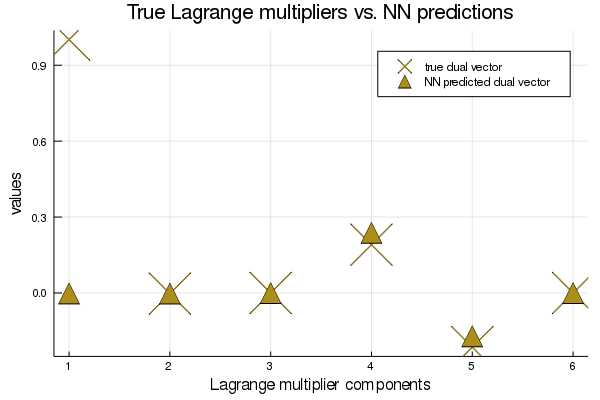

In [197]:
true_dual_vec = [[1.00237, -0.000229532, 0.0, 0.237358, -0.0254306, 0.0], [0.000847697, -0.000254295, 0.0, 0.0847697, -0.0254301, 0.0],[0.00127155, -0.000254295, 0.0, 0.127155, -0.0254301, 0.0], [10.7855, -0.0035167, 0.0, 7.12615, -0.249165, 0.0],[1.00118, -0.00271131, 0.0, 0.190929, -0.214208, 0.0]]
NN_dual_vec = [[-0.00160321, 4.58636e-5, 0.0, 0.236086, -0.0130076, 0.0], [-0.00160321, -0.000191525, 0.0, 0.0853595, -0.0262639, 0.0],[-0.00160321, -0.000172421, 0.0, 0.127904, -0.0234755, 0.0], [-0.00160321, -0.00181127, 0.0, 0.244473, -0.165692, 0.0], [-0.00160321, -0.00195183, 0.0, 0.238001, -0.17104, 0.0]]

gr(fmt=:png)
plot()
for i in 5:5
# for i in 1:length(true_dual_vec)
    scatter!(true_dual_vec[i],
        marker = (:xcross, 20),
#         markerstrokewidth = 10,
        xlabel = "Lagrange multiplier components",
        ylabel = "values",
        label = "true dual vector",
        color = i,
#         color = i==2 ? 3 : i==1 ? 1 : 2,
        legend = :topright)
    scatter!(NN_dual_vec[i],
        marker = (:utriangle, 10),
        xlabel = "Lagrange multiplier components",
        ylabel = "values",
        label = "NN predicted dual vector",
        color = i,
#         color = i==2 ? 3 : i==1 ? 1 : 2,
        legend = :topright)
    title!("True Lagrange multipliers vs. NN predictions")
end
plot!()

xObs = 1.4f0
yObs = 1.4f0


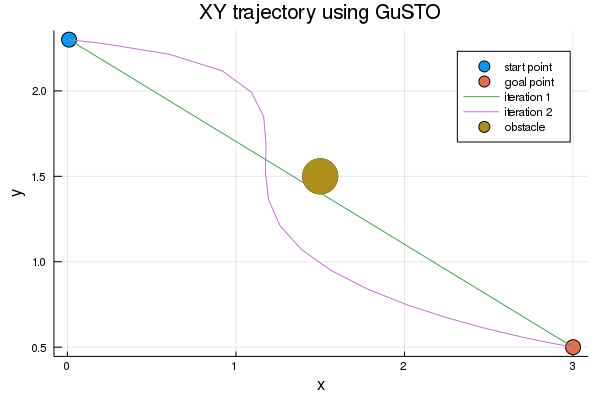

In [201]:
plotXYTrajectories(traj_X_vec)
title!("XY trajectory using GuSTO")
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
@show xObs
@show yObs
xObs = 1.5
yObs = 1.5
widthObs = env.obstacle_set[1].widths[1]
scatter!([xObs],[yObs],markersize=100*widthObs, label="obstacle")



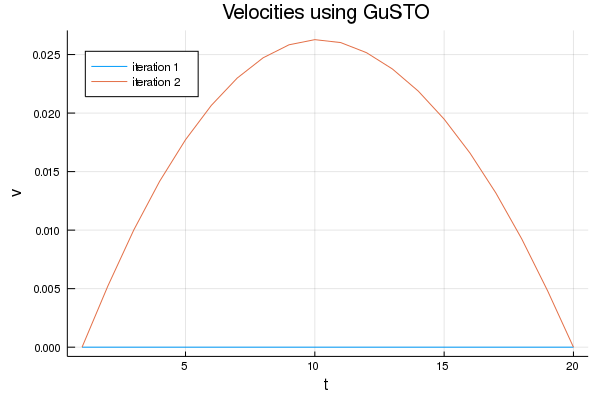

In [172]:
plotVelocities(traj_X_vec)
title!("Velocities using GuSTO")

In [74]:
function carryOutSequence(runs, NNDualParams = nothing, NNDualJSON = nothing, NNDualWeights = nothing)
    println("----------")
    env = setUpEnvironmentNoObstacle()
    N = 20
    x_goal = [3.; 0.5; 0; 0; 0; 0]
    x_init = [0.2; 0.8; 0; 0; 0; 0] 

    tf = 80
    ω0 = 1.0 
    Δ0 = 3.0
    
    time_start = time_ns()
    TOP = []
    TOSgusto = []
    TOP, TOSgusto = setUpProblemAllParams(N, x_init, x_goal, robot, model, env, tf_guess = 200.)
#     TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = tf);    
    traj_init = init_traj_straightline(TOP)
    if !isdefined(TOSgusto, :SCPS)
        SCPP = SCPProblem(TOP)
        SCPS = SCPSolution(SCPP, traj_init)
        TOSgusto.traj, TOSgusto.SCPS = SCPS.traj, SCPS
    end
    
    gusto_setup_time = (time_ns() - time_start)/10^9

    dual_init = zeros(6);
    dual_vec = [dual_init]
    TOSgusto.SCPS.dual = dual_vec[end]

    traj_init_X = traj_init.X
    traj_init_U = traj_init.U

    traj_X_vec = [traj_init_X]
    traj_U_vec = [traj_init_U]
    
    times = []
    
    time_start = time_ns()
    # Set up NN if required
    if !(NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(NNDualParams)
        NN = Keras.load(NNDualJSON, NNDualWeights)
    end
    NN_setup_time = (time_ns() - time_start)/10^9
    
    
    # Set up shooting problem
    N = 20
    SP = ShootingProblem(TOP, TOSgusto.SCPS)
    TOSgusto.SS = ShootingSolution(SP, deepcopy(traj_init))
    SS = TOSgusto.SS
    
    println("GuSTO setup time is $gusto_setup_time")
    println("NN setup time is $NN_setup_time")
    
    while length(runs)>0
        run = popfirst!(runs)
        if startswith(run,"GuSTO-")
            num_iter = parse(Int64, run[7:end])
            println("Doing $num_iter iteration(s) of GuSTO")
            traj = Trajectory(traj_X_vec[end], traj_U_vec[end], tf)
            # Set dual to the end of dual_vec
            if !isdefined(TOSgusto, :SCPS)
                println("defining SCPS")
                SCPP = SCPProblem(TOP)
                SCPS = SCPSolution(SCPP, traj)
                TOSgusto.traj, TOSgusto.SCPS = SCPS.traj, SCPS
            end
            TOSgusto.traj = traj
            TOSgusto.SCPS.dual = dual_vec[end]
            solve_gusto_jump!(TOSgusto.SCPS, TOSgusto.SCPS.SCPP, "Ipopt", max_iter=num_iter, print_level=1)

#             solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj, "Ipopt", max_iter=num_iter, print_level=1);
            iter_times = TOSgusto.SCPS.iter_elapsed_times
            @show iter_times
            @show TOSgusto.SCPS.J_true
            num_actual_iter = (length(iter_times)>num_iter+1) ? num_iter : length(iter_times)-1
            append!(times, iter_times[end-(num_actual_iter-1):end])
            push!(dual_vec, TOSgusto.SCPS.dual)
            push!(traj_X_vec, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec, TOSgusto.SCPS.traj.U)
            if (TOSgusto.SCPS.converged)
                println("GuSTO converged!")
                println("Cost reported: $(TOSgusto.SCPS.J_true)")
            end
        elseif startswith(run,"NNDual-")
            num_iter = parse(Int64, run[8:end])
            if (NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
                println("Error: one or more of the NN duals filenames is missing")
            else
                println("Doing $num_iter iteration(s) of NN- dual")
                if isdefined(TOSgusto, :SCPS) && isdefined(TOSgusto.SCPS, :param) && isdefined(TOSgusto.SCPS.param, :alg)
                    ω = TOSgusto.SCPS.param.alg.ω_vec[end]
                    Δ = TOSgusto.SCPS.param.alg.Δ_vec[end]
                else 
                    ω = ω0
                    Δ = Δ0
                end
                NN_input = createNNInput(traj_X_vec[end], traj_U_vec[end], ω, Δ, xMin, xRange, dual_vec[end])
                NN_inter = NN_input
                for i=1:num_iter
                    time_start = time_ns()
                    
                    NN_output = NN(NN_inter)
                    output_dual = recoverDualfromNNOutput(NN_output, yMin, yRange)
                    
                    iter_elapsed_time = (time_ns() - time_start)/10^9
                    push!(times, iter_elapsed_time)
                    
                    push!(dual_vec, output_dual)
                    
                    # Just repeating the same trajectories
                    push!(traj_X_vec, traj_X_vec[end])
                    push!(traj_U_vec, traj_U_vec[end])
                    
                    # output dual is input for next iteration of NN
                    NN_inter = vcat(NN_input[1:182], output_dual)
                end
            end
        elseif startswith(run, "Shooting")
            TOSgusto.SS.SP.p0 = dual_vec[end]
            solve!(TOSgusto.SS, TOSgusto.SS.SP)
            push!(times, TOSgusto.SS.iter_elapsed_times[end])
            if TOSgusto.SS.prob_status[end]== Symbol(:Optimal)
                println("Shooting method converged!")
                println("Costs reported: $(TOSgusto.SS.J_true)")
            else
                println("Shooting method did not converge.")
            end
        else
            println("Error: $run is not a supported command. Make sure to append the number of iterations at the end of a command.")
        end
    end
    @show times
    # @show dual_vec
    println("----------")
    return (dual_vec, traj_X_vec, traj_U_vec, times)
end

carryOutSequence (generic function with 4 methods)

In [77]:
paramsFileName = "NoObstacleDualParams.h5"
jsonFileName = "NoObstacleDualMoreEpochs.json"
weightsFileName = "NoObstacleDualWeightsMoreEpochs.h5"

runs = ["GuSTO-100","Shooting"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
@show length(times)
@show sum(times)
@show dual_vec 

runs = ["GuSTO-1","Shooting"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
@show sum(times)
@show dual_vec 

runs = ["NNDual-1", "Shooting"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
@show sum(times)
@show dual_vec

runs = ["GuSTO-20"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)
@show length(times)
@show sum(times)
@show dual_vec 

----------
GuSTO setup time is 0.000511654
NN setup time is 0.018708918
Doing 100 iteration(s) of GuSTO
iter_times = [0.0, 0.0625319, 0.0507705, 0.0553438]
(TOSgusto.SCPS).J_true = Any[0.0, 0.00336112, 0.00336112, 0.00336112]
GuSTO converged!
Cost reported: Any[0.0, 0.00336112, 0.00336112, 0.00336112]
Shooting method converged!
Costs reported: Any[0.00334377]
times = Any[0.0625319, 0.0507705, 0.0553438, 0.0239202]
----------
length(times) = 4
sum(times) = 0.19256642300000001
dual_vec = Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.00237, -0.000229532, 0.0, 0.237358, -0.0254306, 0.0]]
----------
GuSTO setup time is 0.000467535
NN setup time is 0.014121615
Doing 1 iteration(s) of GuSTO
iter_times = [0.0, 0.0354516]
(TOSgusto.SCPS).J_true = Any[0.0]
Shooting method converged!
Costs reported: Any[0.00334377]
times = Any[0.0354516, 0.0183615]
----------
sum(times) = 0.053813181
dual_vec = Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
----------
GuSTO

2-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                         
 [1.00237, -0.000229532, 0.0, 0.237358, -0.0254306, 0.0]

In [220]:
true_dual_vec = [[0.0132453, -0.0132453, 0.0, 0.529811, -0.529811, 0.0],[0.0264905, -0.0132453, 0.0, 1.05962, -0.529811, 0.0]]
length(true_dual_vec)

2

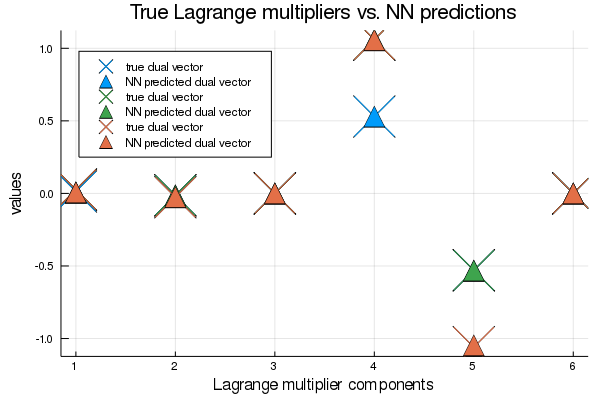

In [236]:
true_dual_vec = [[0.0132453, -0.0132453, 0.0, 0.529811, -0.529811, 0.0],[0.0264905, -0.0132453, 0.0, 1.05962, -0.529811, 0.0]]
NN_dual_vec = [[0.00662263, -0.0133285, 0.0, 0.529134, -0.532488, 0.0],[0.00662263, -0.0133031, 0.0, 1.05891, -0.531829, 0.0]]
true_dual_vec = [[0.0132453, -0.0132453, 0.0, 0.529811, -0.529811, 0.0],[0.0264905, -0.0132453, 0.0, 1.05962, -0.529811, 0.0], [0.0264905, -0.0264907, 0.0, 1.05962, -1.05962, 0.0]]
NN_dual_vec = [[0.00662263, -0.0133285, 0.0, 0.529134, -0.532488, 0.0],[0.00662263, -0.0133031, 0.0, 1.05891, -0.531829, 0.0], [0.00662263, -0.0261973, 0.0, 1.05558, -1.04701, 0.0]]

gr(fmt=:png)
plot()
for i in 1:length(true_dual_vec)
    scatter!(true_dual_vec[i],
        marker = (:xcross, 20),
#         markerstrokewidth = 10,
        xlabel = "Lagrange multiplier components",
        ylabel = "values",
        label = "true dual vector",
        color = i==2 ? 3 : i==1 ? 1 : 2,
        legend = :topleft)
    scatter!(NN_dual_vec[i],
        marker = (:utriangle, 10),
        xlabel = "Lagrange multiplier components",
        ylabel = "values",
        label = "NN predicted dual vector",
        color = i==2 ? 3 : i==1 ? 1 : 2,
        legend = :topleft)
    title!("True Lagrange multipliers vs. NN predictions")
end
plot!()

In [103]:
runs = ["GuSTO-1", "GuSTO-1"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs)

runs = ["GuSTO-2"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs)

runs = ["NNDual-2"]
paramsFileName = "NoObstacleDualParams.h5"
jsonFileName = "NoObstacleDualMoreEpochs.json"
weightsFileName = "NoObstacleDualWeightsMoreEpochs.h5"
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)

runs = ["GuSTO-1","Shooting"]
paramsFileName = "NoObstacleDualParams.h5"
jsonFileName = "NoObstacleDualMoreEpochs.json"
weightsFileName = "NoObstacleDualWeightsMoreEpochs.h5"
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)

runs = ["GuSTO-12"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs)

runs = ["NNDual-1","GuSTO-12"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)



----------
GuSTO setup time is 0.000443621
NN setup time is 3.4e-8
Doing 1 iteration(s) of GuSTO
(TOSgusto.SCPS).converged = false
Doing 1 iteration(s) of GuSTO
(TOSgusto.SCPS).converged = false
times = Any[0.0153655, 0.0153294]
----------
----------
GuSTO setup time is 0.002633158
NN setup time is 4.4e-8
Doing 2 iteration(s) of GuSTO
(TOSgusto.SCPS).converged = false
times = Any[0.0272929]
----------
----------
GuSTO setup time is 0.003056253
NN setup time is 0.022514653
Doing 2 iteration(s) of NN- dual
times = Any[0.00187995, 0.00888877]
----------
----------
GuSTO setup time is 0.005540173
NN setup time is 0.026438266
Doing 1 iteration(s) of GuSTO
(TOSgusto.SCPS).converged = false
(TOSgusto.SS).prob_status = Symbol[:NA, :Optimal, :Optimal, :Optimal]
(TOSgusto.SCPS).converged = true
(TOSgusto.SCPS).iterations = 3
Shooting not supported yet
times = Any[0.0337921]
----------
----------
GuSTO setup time is 0.000444234
NN setup time is 4.5e-8
Doing 12 iteration(s) of GuSTO
(TOSgusto.SCPS

(Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00662263, -0.0133285, 0.0, 0.529134, -0.532488, 0.0], [0.0132453, -0.0132453, 0.0, 0.529811, -0.529811, 0.0]], Array{Float64,2}[[2.0 2.05263 … 2.94737 3.0; 1.5 1.44737 … 0.552632 0.5; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [2.0 2.05263 … 2.94737 3.0; 1.5 1.44737 … 0.552632 0.5; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [2.0 2.00774 … 2.99226 3.0; 1.5 1.49226 … 0.507737 0.5; … ; 6.9672e-30 -0.00367485 … -0.00367485 -1.11445e-26; 0.0 0.0 … 0.0 0.0]], Array{Float64,2}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0150097 0.0141759 … -0.0141759 -0.0150097; -0.0150097 -0.0141759 … 0.0141759 0.0150098; 0.0 0.0 … 0.0 0.0]], Any[0.00151603, 0.0779477, 0.0534356, 0.0301485])

# Just get shooting method to work

In [62]:
# env = setUpEnvironmentNoObstacle()
env = Table(:stanford);
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
x_init = [2.0; 0.8; 0; 0; 0; 0] 

tf = 80

TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = tf);    
traj_init = init_traj_straightline(TOP)
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0)
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.dual
# [0.0132453, -0.00397358, 0.0, 0.529811, -0.158943, 0.0]
# @show TOSgusto.SCPS.traj.X
solve_SCPshooting!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=10, print_level=0)

@show TOSgusto.SS.prob_status
@show TOSgusto.SS.convergence_measure

# @show TOSgusto.SCPS.dual

((TOSgusto.SCPS).traj).X = [2.0 2.00774 2.03028 2.06609 2.1134 2.17042 2.23541 2.30659 2.38218 2.46043 2.53957 2.61782 2.69341 2.76459 2.82958 2.8866 2.93391 2.96972 2.99226 3.0; 0.8 0.797679 0.790915 0.780172 0.765981 0.748873 0.729377 0.708024 0.685345 0.66187 0.63813 0.614655 0.591976 0.570623 0.551127 0.534019 0.519828 0.509085 0.502321 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.00367485 0.0070347 0.00997458 0.0124945 0.0145944 0.0162743 0.0175343 0.0183742 0.0187942 0.0187942 0.0183742 0.0175343 0.0162743 0.0145944 0.0124945 0.00997458 0.0070347 0.00367485 0.0; 0.0 -0.00110245 -0.00211041 -0.00299237 -0.00374834 -0.00437831 -0.00488229 -0.00526028 -0.00551227 -0.00563826 -0.00563826 -0.00551227 -0.00526028 -0.0048823 -0.00437832 -0.00374835 -0.00299238 -0.00211041 -0.00110246 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
(TOSgusto.SCPS).converged = true
(TOSgusto.SCPS).dual = [0.0132453, -0.00

4-element Array{Float64,1}:
 NaN                     
   0.033307301263938466  
   1.1029446687168453e-12
   2.2782261634438145e-13

In [94]:
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
x_init = [2.0; 0.8; 0; 0; 0; 0] 
tf = 80

TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = tf);    
traj = init_traj_straightline(TOP)

if !isdefined(TOSgusto, :SCPS)
    SCPP = SCPProblem(TOP)
    SCPS = SCPSolution(SCPP, traj)
    TOSgusto.traj, TOSgusto.SCPS = SCPS.traj, SCPS
end

SP = ShootingProblem(TOP, TOSgusto.SCPS)
TOSgusto.SS = ShootingSolution(SP, deepcopy(traj_init))
SS = TOSgusto.SS

solve_gusto_jump!(TOSgusto.SCPS, TOSgusto.SCPS.SCPP, "Ipopt", max_iter=100, print_level=0)
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.dual
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.J_true
@show TOSgusto.SS.J_true
@show TOSgusto.SS.SP.p0
solution_dual = TOSgusto.SCPS.dual
solution_dual = [0.0132453, -0.00397358, 0.0, 0.529811, -0.158943, 0.0];
ss_sol = solve!(TOSgusto.SS, TOSgusto.SS.SP)
@show TOSgusto.SS.prob_status

@show TOSgusto.SS.convergence_measure

@show TOSgusto.SCPS.iterations

@show TOSgusto.SS.converged
TOSgusto.SS.SP.p0 = solution_dual
@show TOSgusto.SS.SP.p0
ss_sol = solve!(TOSgusto.SS, TOSgusto.SS.SP)
@show TOSgusto.SS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SS.convergence_measure
@show TOSgusto.SS.prob_status[end]
@show TOSgusto.SS.prob_status[end]== Symbol(:Optimal)

# If successful shooting runs have converged, exit
# conv_iter_spread = 2
# if SCPS.iterations > conv_iter_spread && sum(SS.convergence_measure[end-conv_iter_spread+1:end]) <= SCPS.param.convergence_threshold
# SS.converged = true
# # TODO: Check inequality constraints
# copy!(TOS.traj, SS.traj)
# TOS.total_time = SCPS.total_time + sum(SS.iter_elapsed_times)
# return
# end

((TOSgusto.SCPS).traj).X = [2.0 2.00774 2.03028 2.06609 2.1134 2.17042 2.23541 2.30659 2.38218 2.46043 2.53957 2.61782 2.69341 2.76459 2.82958 2.8866 2.93391 2.96972 2.99226 3.0; 0.8 0.797679 0.790915 0.780172 0.765981 0.748873 0.729377 0.708024 0.685345 0.66187 0.63813 0.614655 0.591976 0.570623 0.551127 0.534019 0.519828 0.509085 0.502321 0.5; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.00367485 0.0070347 0.00997458 0.0124945 0.0145944 0.0162743 0.0175343 0.0183742 0.0187942 0.0187942 0.0183742 0.0175343 0.0162743 0.0145944 0.0124945 0.00997458 0.0070347 0.00367485 0.0; 0.0 -0.00110245 -0.00211041 -0.00299237 -0.00374834 -0.00437831 -0.00488229 -0.00526028 -0.00551227 -0.00563826 -0.00563826 -0.00551227 -0.00526028 -0.0048823 -0.00437832 -0.00374835 -0.00299238 -0.00211041 -0.00110246 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]
(TOSgusto.SCPS).converged = true
(TOSgusto.SCPS).dual = [0.0132453, -0.00

true

# Add NN for duals to GuSTO

In [56]:
@load "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterWithDuals2.jld2" train_input_collected_first_only train_output_collected_first_only
@show size(train_input_collected_first_only)
@show train_input_collected_first_only[1:10, 183:188]
@show size(train_output_collected_first_only)
@show train_input_collected_first_only[1:10, 181:186]
# Note that they all start with 0s

size(train_input_collected_first_only) = (520, 188)
train_input_collected_first_only[1:10, 183:188] = [0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0]
size(train_output_collected_first_only) = (520, 186)
train_input_collected_first_only[1:10, 181:186] = [1.0 3.0 0.0 0.0 0.0 0.0; 1.0 3.0 0.0 0.0 0.0 0.0; 1.0 3.0 0.0 0.0 0.0 0.0; 1.0 3.0 0.0 0.0 0.0 0.0; 1.0 3.0 0.0 0.0 0.0 0.0; 1.0 3.0 0.0 0.0 0.0 0.0; 1.0 3.0 0.0 0.0 0.0 0.0; 1.0 3.0 0.0 0.0 0.0 0.0; 1.0 3.0 0.0 0.0 0.0 0.0; 1.0 3.0 0.0 0.0 0.0 0.0]


10×6 Array{Float64,2}:
 1.0  3.0  0.0  0.0  0.0  0.0
 1.0  3.0  0.0  0.0  0.0  0.0
 1.0  3.0  0.0  0.0  0.0  0.0
 1.0  3.0  0.0  0.0  0.0  0.0
 1.0  3.0  0.0  0.0  0.0  0.0
 1.0  3.0  0.0  0.0  0.0  0.0
 1.0  3.0  0.0  0.0  0.0  0.0
 1.0  3.0  0.0  0.0  0.0  0.0
 1.0  3.0  0.0  0.0  0.0  0.0
 1.0  3.0  0.0  0.0  0.0  0.0

In [82]:
a = rand(1,10)
d = zeros(1,6)
dn = zeros(6)
hcat(a,d)
hcat(a,dn')

1×16 Array{Float64,2}:
 0.105082  0.104167  0.721515  0.660382  …  0.0  0.0  0.0  0.0  0.0  0.0

In [84]:
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
x_init = [0.2; 1.4; 0; 0; 0; 0] 

TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
traj_init = init_traj_straightline(TOP)

traj_init_X = traj_init.X
traj_init_U = traj_init.U

duals_init = zeros(6);
dual_vec = [duals_init]

ω0 = 1.0 
Δ0 = 3.0

filename = "NoObstacleDualParams.h5"
xMin, yMin, xRange, yRange = getDataParamsFromHDF5(filename)

NN_input = createNNInput(traj_init_X, traj_init_U, ω0, Δ0, xMin, xRange, duals_init)

jsonFileName = "NoObstacleDualMoreEpochs.json"
weightsFileName = "NoObstacleDualWeightsMoreEpochs.h5"
NN = Keras.load(jsonFileName, weightsFileName)

NN_output = NN(NN_input)

output_dual = recoverDualfromNNOutput(NN_output, yMin, yRange)

push!(dual_vec, output_dual)



# SCPS = TOSgusto.SCPS 
# SCPP = TOSgusto.SCPS.SCPP

# solve_gusto_jump_NN!(SCPS, SCPP, jsonFileName, weightsFileName, "Ipopt", max_iter=1, print_level=0)

2-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]                        
 [0.00662263, -0.0119747, 0.0, 1.48039, -0.477437, 0.0]

In [ ]:
# Run one iteration of GuSTO and compare duals with one run of NN

In [251]:
runs = ["GuSTO", "NN","GuSTO","NN"]
@show r=popfirst!(runs)
@show r=popfirst!(runs)
@show length(runs)
r=popfirst!(runs)
@show length(runs)

r = popfirst!(runs) = "GuSTO"
r = popfirst!(runs) = "NN"
length(runs) = 2
length(runs) = 1


1

In [149]:
run = "GuSTO-12"
@show startswith(run,"GuSTO-")
@show num = parse(Int64,run[7:end])

startswith(run, "GuSTO-") = true
num = parse(Int64, run[7:end]) = 12


12

# Carry out entire sequence

In [349]:
function carryOutSequence(runs, NNDualParams = nothing, NNDualJSON = nothing, NNDualWeights = nothing)
    println("----------")
    env = setUpEnvironmentNoObstacle()
    N = 20
    x_goal = [3.; 0.5; 0; 0; 0; 0]
    x_init = [2.0; 1.5; 0; 0; 0; 0] 

    tf = 80
    ω0 = 1.0 
    Δ0 = 3.0
    
    time_start = time_ns()
    TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = tf);    
    traj_init = init_traj_straightline(TOP)
    gusto_setup_time = (time_ns() - time_start)/10^9

    dual_init = zeros(6);
    dual_vec = [dual_init]

    traj_init_X = traj_init.X
    traj_init_U = traj_init.U

    traj_X_vec = [traj_init_X]
    traj_U_vec = [traj_init_U]
    
    times = []
    
    time_start = time_ns()
    # Set up NN if required
    if !(NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(NNDualParams)
        NN = Keras.load(NNDualJSON, NNDualWeights)
    end
    NN_setup_time = (time_ns() - time_start)/10^9
    
    
    
    println("GuSTO setup time is $gusto_setup_time")
    println("NN setup time is $NN_setup_time")
    
    while length(runs)>0
        run = popfirst!(runs)
        if startswith(run,"GuSTO-")
            num_iter = parse(Int64, run[7:end])
            println("Doing $num_iter iteration(s) of GuSTO")
            traj = Trajectory(traj_X_vec[end], traj_U_vec[end], tf)
            # Set dual to the end of dual_vec
            if !isdefined(TOSgusto, :SCPS)
                SCPP = SCPProblem(TOP)
                SCPS = SCPSolution(SCPP, traj)
                TOSgusto.traj, TOSgusto.SCPS = SCPS.traj, SCPS
            end                
            TOSgusto.SCPS.dual = dual_vec[end]
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj, "Ipopt", max_iter=num_iter, print_level=1);
            iter_times = TOSgusto.SCPS.iter_elapsed_times
            num_actual_iter = (length(iter_times)>num_iter+1) ? num_iter : length(iter_times)-1
            append!(times, iter_times[end-(num_actual_iter-1):end])
            push!(dual_vec, TOSgusto.SCPS.dual)
            push!(traj_X_vec, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec, TOSgusto.SCPS.traj.U)
            @show TOSgusto.SCPS.converged
        elseif startswith(run,"NNDual-")
            num_iter = parse(Int64, run[8:end])
            if (NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
                println("Error: one or more of the NN duals filenames is missing")
            else
                println("Doing $num_iter iteration(s) of NN- dual")
                if isdefined(TOSgusto, :SCPS)
                    ω = TOSgusto.SCPS.param.alg.ω_vec[end]
                    Δ = TOSgusto.SCPS.param.alg.Δ_vec[end]
                else 
                    ω = ω0
                    Δ = Δ0
                end
                NN_input = createNNInput(traj_X_vec[end], traj_U_vec[end], ω, Δ, xMin, xRange, dual_vec[end])
                NN_inter = NN_input
                for i=1:num_iter
                    time_start = time_ns()
                    
                    NN_output = NN(NN_inter)
                    output_dual = recoverDualfromNNOutput(NN_output, yMin, yRange)
                    
                    iter_elapsed_time = (time_ns() - time_start)/10^9
                    push!(times, iter_elapsed_time)
                    
                    push!(dual_vec, output_dual)
                    
                    # Just repeating the same trajectories
                    push!(traj_X_vec, traj_X_vec[end])
                    push!(traj_U_vec, traj_U_vec[end])
                    
                    # output dual is input for next iteration of NN
                    NN_inter = vcat(NN_input[1:182], output_dual)
                end
            end
        elseif startswith(run, "Shooting")
            # Set up shooting method
#             if !isdefined(TOSgusto, :SCPS)
#                 println("ERROR: run GuSTO once before attempting shooting method")
#             end
#             @show dual_vec
#             @show TOSgusto.SCPS.dual
#             SP = ShootingProblem(TOP, TOSgusto.SCPS)
#             TOS_SCPS  = TrajectoryOptimizationSolution(TOP)
#             traj = Trajectory(traj_X_vec[end], traj_U_vec[end], tf)
            solve_SCPshooting!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0)
#             SS = ShootingSolution(SP, deepcopy(traj))
#             TOSgusto.SS = SS
#             ss_sol = solve!(SS, SP)
#             @show ss_sol
            @show TOSgusto.SS.prob_status
#             @show SS.convergence_measure
            @show TOSgusto.SCPS.converged
            @show TOSgusto.SCPS.iterations
            println("$run not supported yet")
        else
            println("Error: $run is not a supported command. Make sure to append the number of iterations at the end of a command.")
        end
    end
    @show times
    # @show dual_vec
    println("----------")
    return (dual_vec, traj_X_vec, traj_U_vec, times)
end

carryOutSequence (generic function with 4 methods)

In [350]:
paramsFileName = "NoObstacleDualParams.h5"
jsonFileName = "NoObstacleDualMoreEpochs.json"
weightsFileName = "NoObstacleDualWeightsMoreEpochs.h5"

# runs = ["GuSTO-10","Shooting"]
# (dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)

runs = ["Shooting"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)



----------
GuSTO setup time is 0.206077213
NN setup time is 0.033369235
202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020202020(TOSgusto.SS).prob_status = Symbol[:NA, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverged, :Diverge

(Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], Array{Float64,2}[[2.0 2.05263 … 2.94737 3.0; 1.5 1.44737 … 0.552632 0.5; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], Array{Float64,2}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], Any[])

In [300]:
runs = ["GuSTO-1", "GuSTO-1"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs)

runs = ["GuSTO-2"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs)

runs = ["NNDual-2"]
paramsFileName = "NoObstacleDualParams.h5"
jsonFileName = "NoObstacleDualMoreEpochs.json"
weightsFileName = "NoObstacleDualWeightsMoreEpochs.h5"
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)

runs = ["GuSTO-1","Shooting"]
paramsFileName = "NoObstacleDualParams.h5"
jsonFileName = "NoObstacleDualMoreEpochs.json"
weightsFileName = "NoObstacleDualWeightsMoreEpochs.h5"
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)

runs = ["GuSTO-12"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs)

runs = ["NNDual-1","GuSTO-12"]
(dual_vec, traj_X_vec, traj_U_vec, times) = carryOutSequence(runs, paramsFileName, jsonFileName, weightsFileName)



----------
GuSTO setup time is 0.000388021
NN setup time is 3.8e-8
Doing 1 iteration(s) of GuSTO
(TOSgusto.SCPS).converged = false
Doing 1 iteration(s) of GuSTO
(TOSgusto.SCPS).converged = false
times = Any[0.0486448, 0.0349633]
----------
----------
GuSTO setup time is 0.000363854
NN setup time is 3.8e-8
Doing 2 iteration(s) of GuSTO
(TOSgusto.SCPS).converged = false
times = Any[0.0313123, 0.0520215]
----------
----------
GuSTO setup time is 0.000479346
NN setup time is 0.023023574
Doing 2 iteration(s) of NN- dual
times = Any[0.00205017, 0.00612652]
----------
----------
GuSTO setup time is 0.000626158
NN setup time is 0.013485301
Doing 1 iteration(s) of GuSTO
(TOSgusto.SCPS).converged = false
Shooting not supported yet
times = Any[0.0665648]
----------
----------
GuSTO setup time is 0.000501989
NN setup time is 9.2e-8
Doing 12 iteration(s) of GuSTO
(TOSgusto.SCPS).converged = true
times = Any[0.0351592, 0.0772894, 0.0347946]
----------
----------
GuSTO setup time is 0.00046514
NN set

(Array{Float64,1}[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00662263, -0.0119747, 0.0, 1.48039, -0.477437, 0.0], [1.03709, -0.0119042, 0.0, 1.48347, -0.47683, 0.0]], Array{Float64,2}[[0.2 0.347368 … 2.85263 3.0; 1.4 1.35263 … 0.547368 0.5; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.2 0.347368 … 2.85263 3.0; 1.4 1.35263 … 0.547368 0.5; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.2 0.221662 … 2.97834 3.0; 1.4 1.39304 … 0.506963 0.5; … ; -3.19773e-27 -0.00330736 … -0.00330736 1.02427e-28; 0.0 0.0 … 0.0 0.0]], Array{Float64,2}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0420273 0.0396925 … -0.0396924 -0.0420273; -0.0135088 -0.0127583 … 0.0127583 0.0135088; 0.0 0.0 … 0.0 0.0]], Any[0.0082591, 0.0762368, 0.0507224, 0.0506388])

In [294]:
a = rand(188)
b = rand(6)
@show size(a)
@show size(b)
c=vcat(a,b)
@show size(c)
times = []
c = [0.0, 0.264697, 0.0386061]
num_iter = 2
@show c[end-2:end]
push!(times,c[end-(num_iter-1):end])
k = [0.5]
a = [0.2,0.1, 0.4]
# @show push!(k,a[end-1:end])
@show a[end-1:end]
@show append!(k,a[end-1:end])


size(a) = (188,)
size(b) = (6,)
size(c) = (194,)
c[end - 2:end] = [0.0, 0.264697, 0.0386061]
a[end - 1:end] = [0.1, 0.4]
append!(k, a[end - 1:end]) = [0.5, 0.1, 0.4]


3-element Array{Float64,1}:
 0.5
 0.1
 0.4

In [ ]:
# Run GuSTO till convergence and plot all the duals 

In [ ]:
# Run one run of NN, send that to GuSTO and plot iteration of duals

# Check if starting point is inside obstacle

In [214]:
function isInsideObstacle(xVal,yVal)
    xPos1 = 1.00
    yPos1 = 2.00
    xPos2 = 1.50
    yPos2 = 1.50
    buffer = 0.3
    if (xVal <=xPos1+buffer && xVal >=xPos1-buffer && yVal<=yPos1+buffer && yVal>=yPos1-buffer)
        return true
    elseif (xVal <=xPos2+buffer && xVal >=xPos2-buffer && yVal<=yPos2+buffer && yVal>=yPos2-buffer)
        return true
    else
        return false
    end
end

isInsideObstacle (generic function with 1 method)

# Extract duals from GuSTO runs for 2 obstacle case

In [215]:
env = setUpEnvironmentTwoObstacle()
N = 20
robot = Freeflyer()
model = FreeflyerSE2()

x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 700
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 5

# Input is now (6*20) + (3*20) + 2 +6 = 188 
# Output is now 6*20) + (3*20) +6 = 186
train_input_collected_first_only = Array{Float64}(undef,0,188)
train_output_collected_first_only = Array{Float64}(undef,0,186)

train_input_collected = Array{Float64}(undef,0,188)
train_output_collected = Array{Float64}(undef,0,186)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        if isInsideObstacle(xVal,yVal)
            continue
        else
            x_init = [xVal; yVal; 0; 0; 0; 0] 
            TOP, TOSgusto = setUpProblemAllParams(N, x_init, x_goal, robot, model, env;tf_guess = 200.)
            # TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
            traj_init = init_traj_straightline(TOP)

            traj_X_vec = [traj_init.X]
            traj_U_vec = [traj_init.U]
            traj_X_vec_first_only = [traj_init.X]
            traj_U_vec_first_only = [traj_init.U]
            dual_vec = [zeros(6)]

            # Solve one step at a time with IPOPT
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
            push!(traj_X_vec, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec, TOSgusto.SCPS.traj.U)
            push!(traj_X_vec_first_only, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec_first_only, TOSgusto.SCPS.traj.U)
            push!(dual_vec, TOSgusto.SCPS.dual)
            iterCount = 1

            while !TOSgusto.SCPS.converged && iterCount <max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
                solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
                if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                    push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                    push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                    push!(dual_vec, TOSgusto.SCPS.dual)
                    iterCount = iterCount + 1
                    @show iterCount
                end
            end

            if TOSgusto.SCPS.scp_status[end] == :OK 
                if TOSgusto.SCPS.converged
                    println("Saving data solution converged and is OK")
                    train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec, dual_vec)
                    train_input_first_only, train_output_first_only = createTrainingInputAndOutput(traj_X_vec_first_only, traj_U_vec_first_only, TOSgusto.SCPS.param.alg.ω_vec[1:2], TOSgusto.SCPS.param.alg.Δ_vec[1:2], dual_vec[1:2])

                    train_input_collected = vcat(train_input_collected, train_input)
                    train_output_collected = vcat(train_output_collected, train_output)
                    train_input_collected_first_only = vcat(train_input_collected_first_only, train_input_first_only)
                    train_output_collected_first_only = vcat(train_output_collected_first_only, train_output_first_only)
                    # Verifying that the correct duals are being stored
                    # @show train_input[:,183:188]
                    # @show train_output[:,181:186]
                    # @show dual_vec
                else
                    println("solution is ok but DID NOT converge")
                end
            else
                @show TOSgusto.SCPS.scp_status
                println("solution DID NOT end in OK")
                if TOSgusto.SCPS.converged
                    println("solution converged")
                else
                    println("solution DID NOT converge")
                end
            end

            problemNumber = problemNumber + 1
            @save "TwoObstacleWithDuals.jld2" train_input_collected train_output_collected
            @save "TwoObstacleOnly1IterWithDuals.jld2" train_input_collected_first_only train_output_collected_first_only
        end
    end
end


problemNumber = 1
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 2
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 3
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 4
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 5
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 6
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 7
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 8
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 9
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 10
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 11
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converge


problemNumber = 62
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 63
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 64
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
Saving data solution converged and is OK

problemNumber = 65
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 66
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 67
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 68
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 69
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 70
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 71
ite

iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 121
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 122
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 123
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 124
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 125
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 126
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraint


problemNumber = 173
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 174
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 175
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 176
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 177
iterCount = 2
iterCount = 3
Saving data soluti

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 225

problemNumber = 225

problemNumber = 225

problemNumber = 225

problemNumber = 225

problemNumber = 225

problemNumber = 225

problemNumber = 225
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 226
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
Saving data solution converged and is OK

problemNumber = 227
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 228
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
s


problemNumber = 268
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 269
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 270

problemNumber = 270

problemNumber = 270

problemNumber = 270

problemNumber = 270

problemNumber = 270

problemNumber = 270

problemNumber = 270
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 271
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 272
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
Saving data solution converged and is OK

problemNumber = 273
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 274
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 275
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problem


problemNumber = 320
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 321
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 322
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 323
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 324
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 325
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 326
iterCount = 2
iterCount = 3
Saving data solution converge


problemNumber = 375
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 376
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 377
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 378
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstrai


problemNumber = 433
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 434
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 435
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 436
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 437
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 438
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 439
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 440
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 441
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 442
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 443
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNu

iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 500
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 501
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 502
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 503
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 504
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 505
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = 


problemNumber = 559
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 560
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 561
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 562
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 563
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 564
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 565
iterCount = 2
iterCount = 3
Saving data solution converge

# Extract duals from GuSTO runs for 1 obstacle case

In [28]:
env = setUpEnvironmentOneObstacle()
N = 20
robot = Freeflyer()
model = FreeflyerSE2()

x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 700
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 5

# Input is now (6*20) + (3*20) + 2 +6 = 188 
# Output is now 6*20) + (3*20) +6 = 186
train_input_collected_first_only = Array{Float64}(undef,0,188)
train_output_collected_first_only = Array{Float64}(undef,0,186)

train_input_collected = Array{Float64}(undef,0,188)
train_output_collected = Array{Float64}(undef,0,186)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        if isInsideObstacle(xVal,yVal)
            continue
        else
            x_init = [xVal; yVal; 0; 0; 0; 0] 
            TOP, TOSgusto = setUpProblemAllParams(N, x_init, x_goal, robot, model, env;tf_guess = 200.)
            # TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
            traj_init = init_traj_straightline(TOP)

            traj_X_vec = [traj_init.X]
            traj_U_vec = [traj_init.U]
            traj_X_vec_first_only = [traj_init.X]
            traj_U_vec_first_only = [traj_init.U]
            dual_vec = [zeros(6)]

            # Solve one step at a time with IPOPT
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
            push!(traj_X_vec, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec, TOSgusto.SCPS.traj.U)
            push!(traj_X_vec_first_only, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec_first_only, TOSgusto.SCPS.traj.U)
            push!(dual_vec, TOSgusto.SCPS.dual)
            iterCount = 1

            while !TOSgusto.SCPS.converged && iterCount <max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
                solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
                if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                    push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                    push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                    push!(dual_vec, TOSgusto.SCPS.dual)
                    iterCount = iterCount + 1
                    @show iterCount
                end
            end

            if TOSgusto.SCPS.scp_status[end] == :OK 
                if TOSgusto.SCPS.converged
                    println("Saving data solution converged and is OK")
                    train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec, dual_vec)
                    train_input_first_only, train_output_first_only = createTrainingInputAndOutput(traj_X_vec_first_only, traj_U_vec_first_only, TOSgusto.SCPS.param.alg.ω_vec[1:2], TOSgusto.SCPS.param.alg.Δ_vec[1:2], dual_vec[1:2])

                    train_input_collected = vcat(train_input_collected, train_input)
                    train_output_collected = vcat(train_output_collected, train_output)
                    train_input_collected_first_only = vcat(train_input_collected_first_only, train_input_first_only)
                    train_output_collected_first_only = vcat(train_output_collected_first_only, train_output_first_only)
                    # Verifying that the correct duals are being stored
                    # @show train_input[:,183:188]
                    # @show train_output[:,181:186]
                    # @show dual_vec
                else
                    println("solution is ok but DID NOT converge")
                end
            else
                @show TOSgusto.SCPS.scp_status
                println("solution DID NOT end in OK")
                if TOSgusto.SCPS.converged
                    println("solution converged")
                else
                    println("solution DID NOT converge")
                end
            end

            problemNumber = problemNumber + 1
            @save "TwoObstacleWithDuals.jld2" train_input_collected train_output_collected
            @save "TwoObstacleOnly1IterWithDuals.jld2" train_input_collected_first_only train_output_collected_first_only
        end
    end
end


problemNumber = 1
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 2
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 3
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 4
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 5
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 6
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 7
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 8
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 9
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 10
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 11
iterCount = 2
iterCount = 3
iterCount = 4
Saving data sol

iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 62
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 63
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 64
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
Saving data solution converged and is OK

problemNumber = 65
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 66
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
Saving data solution converged and is OK

problemNumber = 67
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 68
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 69
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 70
iterCount = 2
iterCount = 3
iter


problemNumber = 120
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 121
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 122
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
Saving data solution converged and is OK

problemNumber = 123
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
Saving data solution converged and is OK

problemNumber = 124
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 125
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 126
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints


problemNumber = 173
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 174
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 175
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 176
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 177
iterCount = 2
iterCount = 3
Saving data soluti


problemNumber = 224
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 225

problemNumber = 225

problemNumber = 225

problemNumber = 225

problemNumber = 225

problemNumber = 225

problemNumber = 225

problemNumber = 225
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
Saving data solution converged and is OK

problemNumber = 226
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 227
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 228
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution 

iterCount = 4
Saving data solution converged and is OK

problemNumber = 268
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 269
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 270

problemNumber = 270

problemNumber = 270

problemNumber = 270

problemNumber = 270

problemNumber = 270

problemNumber = 270

problemNumber = 270
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 271
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
solution is ok but DID NOT converge

problemNumber = 272
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
Saving data solution converged and is OK

problemNumber = 273
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
Saving data solution converged and is OK

problemNumber = 274
iterCount = 2
iterCount = 3
iterCount = 4
Saving data solution converged and is OK

problemNumber = 275
iterCount = 2
iterCount = 3
ite


problemNumber = 319
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 320
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 321
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 322
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 323
iterCount = 2
iterCount = 3
Saving data soluti

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 374
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 375
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 376
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstra


problemNumber = 430
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 431
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 432
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 433
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 434
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 435
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 436
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 437
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 438
iterCount = 2
iterCount = 3
Saving data solution converged and is OK


problemNumber = 494
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 495
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 496
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 497
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 498
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 499
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 500
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 501
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 502
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 503
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :Viola


problemNumber = 557
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 558
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 559
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 560
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstrai

# Extract duals from GuSTO runs 

In [20]:
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 700
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 3

# Input is now (6*20) + (3*20) + 2 +6 = 188 
# Output is now 6*20) + (3*20) +6 = 186
train_input_collected_first_only = Array{Float64}(undef,0,188)
train_output_collected_first_only = Array{Float64}(undef,0,186)

train_input_collected = Array{Float64}(undef,0,188)
train_output_collected = Array{Float64}(undef,0,186)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 

        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        traj_init = init_traj_straightline(TOP)
        
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        traj_X_vec_first_only = [traj_init.X]
        traj_U_vec_first_only = [traj_init.U]
        dual_vec = [zeros(6)]
        
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        push!(traj_X_vec_first_only, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec_first_only, TOSgusto.SCPS.traj.U)
        push!(dual_vec, TOSgusto.SCPS.dual)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                push!(dual_vec, TOSgusto.SCPS.dual)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        
        if TOSgusto.SCPS.scp_status[end] == :OK 
            if TOSgusto.SCPS.converged
                println("Saving data solution converged and is OK")
                train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec, dual_vec)
                train_input_first_only, train_output_first_only = createTrainingInputAndOutput(traj_X_vec_first_only, traj_U_vec_first_only, TOSgusto.SCPS.param.alg.ω_vec[1:2], TOSgusto.SCPS.param.alg.Δ_vec[1:2], dual_vec[1:2])
                
                train_input_collected = vcat(train_input_collected, train_input)
                train_output_collected = vcat(train_output_collected, train_output)
                train_input_collected_first_only = vcat(train_input_collected_first_only, train_input_first_only)
                train_output_collected_first_only = vcat(train_output_collected_first_only, train_output_first_only)
                # Verifying that the correct duals are being stored
                # @show train_input[:,183:188]
                # @show train_output[:,181:186]
                # @show dual_vec
            else
                println("solution is ok but DID NOT converge")
            end
        else
            @show TOSgusto.SCPS.scp_status
            println("solution DID NOT end in OK")
            if TOSgusto.SCPS.converged
                println("solution converged")
            else
                println("solution DID NOT converge")
            end
        end

        problemNumber = problemNumber + 1
        @save "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelWithDuals2.jld2" train_input_collected train_output_collected
        @save "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1IterWithDuals2.jld2" train_input_collected_first_only train_output_collected_first_only
    end
end


problemNumber = 1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 2
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 3
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 4
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 5
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 6
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 7
iterCount = 2
iterCount = 3
Saving data solution converged and is


problemNumber = 73
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 74
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 75
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 76
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 77
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end


problemNumber = 141
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 142
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 143
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 144
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 145
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 146
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 147
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 148
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 149
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 150
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 151
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesC


problemNumber = 209
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 210
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 211
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 212
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 213
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 214
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 215
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 216
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 217
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 218
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 219
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNu


problemNumber = 283
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 284
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 285
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 286
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 287
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 288
iterCount = 2
iterCount = 3
Saving data solution conv

iterCount = 3
Saving data solution converged and is OK

problemNumber = 354
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 355
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 356
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 357
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 358
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 359
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 360
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 361
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol


problemNumber = 421
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 422
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 423
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 424
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 425
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 426
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 427
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 428
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 429
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 430
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 431
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNu


problemNumber = 493
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 494
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 495
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 496
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 497
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 498
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 499
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 500
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 501
iterCount = 2
iterCou


problemNumber = 566
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 567
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 568
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 569
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 570
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 571
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Sym


problemNumber = 634
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 635
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 636
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 637
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 638
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 639
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 640
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 641
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 642
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 643
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 644
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNu

In [43]:
@show dual_vec

UndefVarError: UndefVarError: dual_vec not defined

# Add NN to GuSTO

In [62]:
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
x_init = [0.2; 1.4; 0; 0; 0; 0] 

TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
traj_init = init_traj_straightline(TOP)

traj_init_X = traj_init.X
traj_init_U = traj_init.U

traj_X_vec = [traj_init_X]
traj_U_vec = [traj_init_U]

ω0 = 1.0 
Δ0 = 3.0

filename = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.h5"
xMin, yMin, xRange, yRange = getDataParamsFromHDF5(filename)

NN_input = createNNInput(traj_init_X, traj_init_U, ω0, Δ0, xMin, xRange)

jsonFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.json"
weightsFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedBWeights.h5"
NN = Keras.load(jsonFileName, weightsFileName)

NN_output_diff = NN(NN_input)

output_X, output_U = recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)

push!(traj_X_vec, output_X)
push!(traj_U_vec, output_U)



# SCPS = TOSgusto.SCPS 
# SCPP = TOSgusto.SCPS.SCPP

# solve_gusto_jump_NN!(SCPS, SCPP, jsonFileName, weightsFileName, "Ipopt", max_iter=1, print_level=0)

HERE
["dense_1"]
HERE
["dense_2"]
HERE
["dense_3"]
HERE
["dense_4"]
HERE
["dense_5"]


2-element Array{Array{Float64,2},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]                                                    
 [0.0415327 0.0393664 … -0.0395725 -0.0419772; -0.0136566 -0.0126798 … 0.0127731 0.0136163; 0.0 0.0 … 0.0 0.0]

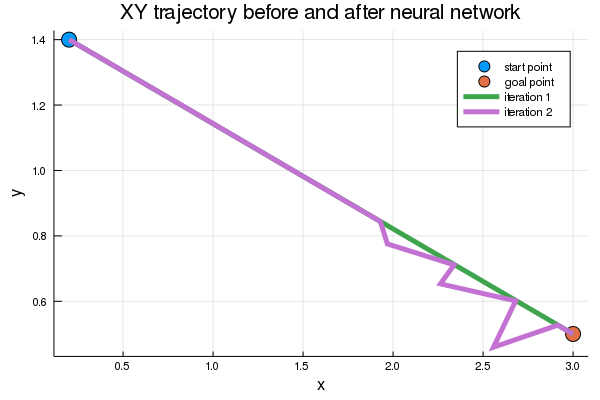

In [65]:
plotXYTrajectories(traj_X_vec)
title!("XY trajectory before and after neural network")

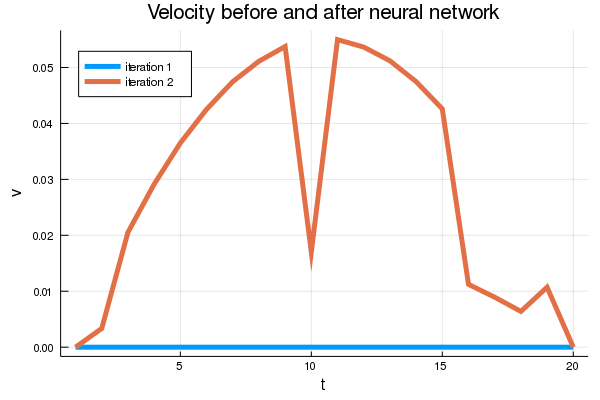

In [68]:
plotVelocities(traj_X_vec)
title!("Velocity before and after neural network")

### Comparison 1: this as a new starting point, compare cost evolution

In [111]:
# Try solving SCP with this new starting point vs with initial straight line

traj_init_NN = Trajectory(output_X, output_U, 80)
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
# @show TOSgusto.SCPS.J_true
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init_NN, "Ipopt", max_iter=10, print_level=1);
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.iterations
costsWithNNInit = TOSgusto.SCPS.J_true

traj_init = init_traj_straightline(TOP)
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80)
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=10, print_level=1);
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.iterations
costsWithStraightInit = TOSgusto.SCPS.J_true


(TOSgusto.SCPS).J_true = Any[0.0566917, 0.0572858, 0.0572858, 0.0572858]
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true]
(TOSgusto.SCPS).iterations = 3
(TOSgusto.SCPS).J_true = Any[0.0, 0.0572858, 0.0572858, 0.0572858]
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true]
(TOSgusto.SCPS).iterations = 3


4-element Array{Any,1}:
 0.0                 
 0.05728578731985084 
 0.057285787319852205
 0.0572857873198522  

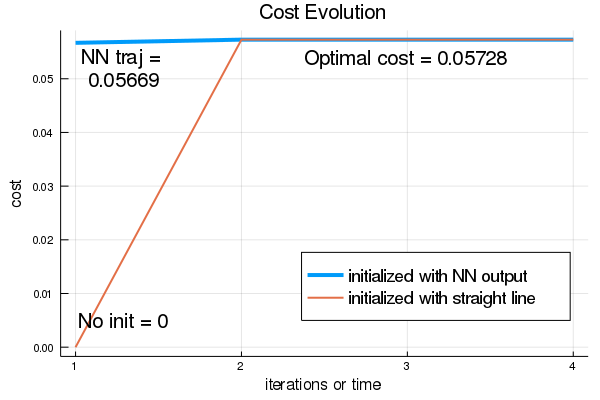

In [114]:
NNcost = 0.05669
Initcost = 0
Finalcost = 0.05728
gr(fmt=:png)
plot()
plot!(costsWithNNInit, label = "initialized with NN output", linewidth = 4)
plot!(costsWithStraightInit, label = "initialized with straight line", linewidth = 2, legendfontsize = 12, legend=:bottomright, annotations=[(1.3,0.052,"NN traj = \n$NNcost"), (1.3,0.005,"No init = $Initcost"), (3.0,0.054,"Optimal cost = $Finalcost")])
title!("Cost Evolution")
xlabel!("iterations or time")
ylabel!("cost")
plot!()

### Compare the trajectory evolution

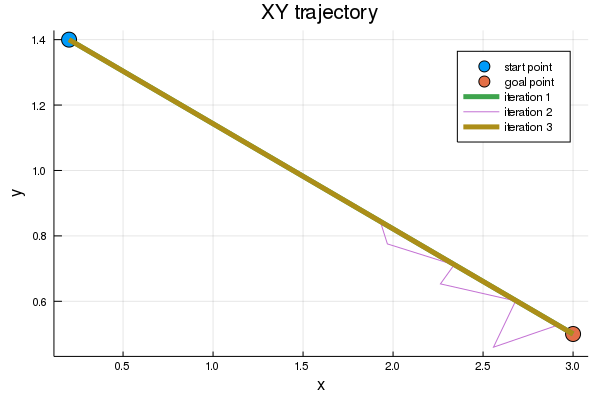

In [115]:
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
plotXYTrajectories(traj_X_vec)


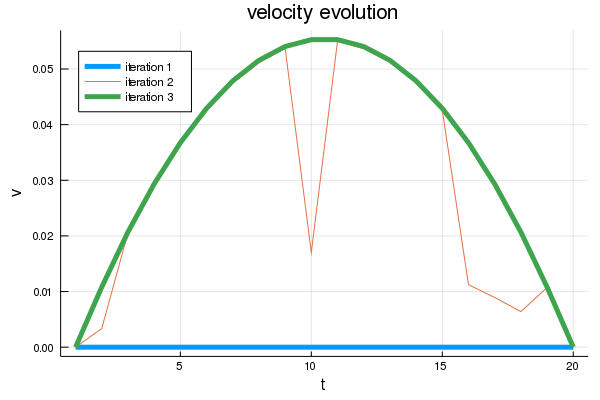

In [116]:
plotVelocities(traj_X_vec)


### Compare time taken

In [298]:
# Try solving SCP with this new starting point vs with initial straight line
setup_time = @elapsed begin
    env = setUpEnvironmentNoObstacle()
    N = 20
    x_goal = [3.; 0.5; 0; 0; 0; 0]
    x_init = [0.2; 1.4; 0; 0; 0; 0] 

    TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
    traj_init = init_traj_straightline(TOP)

    traj_init_X = traj_init.X
    traj_init_U = traj_init.U

    traj_X_vec = [traj_init_X]
    traj_U_vec = [traj_init_U]

    ω0 = 1.0 
    Δ0 = 3.0
    
    load_model_time = @elapsed begin 
        filename = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.h5"
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(filename)

        NN_input = createNNInput(traj_init_X, traj_init_U, ω0, Δ0, xMin, xRange)

        jsonFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.json"
        weightsFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedBWeights.h5"
        NN = Keras.load(jsonFileName, weightsFileName)
    end

end

NN_time = @elapsed begin 
    eval_NN_time = @elapsed NN_output_diff = NN(NN_input)
    output_X, output_U = recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)
end

@show setup_time
@show load_model_time
@show eval_NN_time
@show NN_time

only_gusto_setup_time = @elapsed begin
    TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80)
    traj_init = init_traj_straightline(TOP)
end

first_solve_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=1);
second_solve_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=1);

println("")
@show only_gusto_setup_time
@show first_solve_time
@show second_solve_time

only_gusto_setup_time = @elapsed begin
    TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80)
    traj_init = init_traj_straightline(TOP)
end

two_solves_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=2, print_level=1);
two_more_solves_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=2, print_level=1);
next_two_more_solves_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=2, print_level=1);
println("")
@show only_gusto_setup_time
@show two_solves_time
@show two_more_solves_time
@show next_two_more_solves_time

NN_time = @elapsed begin 
    NN_output_diff = NN(NN_input)
    output_X, output_U = recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)
end
gusto_solve_time = @elapsed begin
traj_init_NN = Trajectory(output_X, output_Y, 80)
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init_NN, "Ipopt", max_iter=1, print_level=1);
end
println("")
@show NN_time
@show gusto_solve_time

setup_time = 0.311942232
load_model_time = 0.308309251
eval_NN_time = 0.008614934
NN_time = 0.01845355

only_gusto_setup_time = 0.007437149
first_solve_time = 0.164153791
second_solve_time = 0.038025489

only_gusto_setup_time = 0.002228432
two_solves_time = 0.108465299
two_more_solves_time = 0.038044583
next_two_more_solves_time = 0.039479017

NN_time = 0.001826741
gusto_solve_time = 0.09058192


0.09058192

In [322]:
# TODO: compute some error bounds by averaging these

NN_only_setup_times = []
NN_only_eval_NN_times = []
one_gusto_setup_times = [] 
one_gusto_eval_once_times = []
two_gusto_setup_times = []
two_gusto_eval_twice_times = []
NN_then_gusto_eval_NN_times = []
NN_then_gusto_eval_gusto_times = []

for i = 1:20
    setup_time = @elapsed begin
        env = setUpEnvironmentNoObstacle()
        N = 20
        x_goal = [3.; 0.5; 0; 0; 0; 0]
        x_init = [0.2; 1.4; 0; 0; 0; 0] 

        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        traj_init = init_traj_straightline(TOP)

        traj_init_X = traj_init.X
        traj_init_U = traj_init.U

        traj_X_vec = [traj_init_X]
        traj_U_vec = [traj_init_U]

        ω0 = 1.0 
        Δ0 = 3.0

        filename = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelParams.h5"
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(filename)

        NN_input = createNNInput(traj_init_X, traj_init_U, ω0, Δ0, xMin, xRange)

        jsonFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedB.json"
        weightsFileName = "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelNormalizedBWeights.h5"
        NN = Keras.load(jsonFileName, weightsFileName)

    end
    push!(NN_only_setup_times, setup_time)
    @show NN_only_setup_times
    
    NN_time = @elapsed begin 
        NN_output_diff = NN(NN_input)
        output_X, output_U = recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)
    end
    push!(NN_only_eval_NN_times, NN_time)

    only_gusto_setup_time = @elapsed begin
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80)
        traj_init = init_traj_straightline(TOP)
    end
    push!(one_gusto_setup_times, only_gusto_setup_time)

    first_solve_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=1);
    push!(one_gusto_eval_once_times, first_solve_time)

    only_gusto_setup_time = @elapsed begin
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80)
        traj_init = init_traj_straightline(TOP)
    end
    push!(two_gusto_setup_times, only_gusto_setup_time)

    two_solves_time = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=2, print_level=1);
    push!(two_gusto_eval_twice_times, two_solves_time)

    NN_time = @elapsed begin 
        NN_output_diff = NN(NN_input)
        output_X, output_U = recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)
    end
    push!(NN_then_gusto_eval_NN_times,NN_time)
    
    gusto_solve_time = @elapsed begin
    traj_init_NN = Trajectory(output_X, output_Y, 80)
    TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init_NN, "Ipopt", max_iter=1, print_level=1);
    end
    push!(NN_then_gusto_eval_gusto_times, gusto_solve_time)
end

using StatsBase
NN_only_setup_times = StatsBase.trim(NN_only_setup_times, prop=0.1)
one_gusto_setup_times = StatsBase.trim(one_gusto_setup_times, prop=0.1)
two_gusto_setup_times = StatsBase.trim(two_gusto_setup_times, prop=0.1)
NN_only_eval_NN_times = StatsBase.trim(NN_only_eval_NN_times, prop=0.1)
NN_then_gusto_eval_NN_times = StatsBase.trim(NN_then_gusto_eval_NN_times, prop=0.1)
one_gusto_eval_once_times = StatsBase.trim(one_gusto_eval_once_times, prop=0.1)
two_gusto_eval_twice_times = StatsBase.trim(two_gusto_eval_twice_times, prop=0.1)
NN_then_gusto_eval_gusto_times = StatsBase.trim(NN_then_gusto_eval_gusto_times, prop=0.1)


setup_times = [mean(NN_only_setup_times); mean(one_gusto_setup_times); mean(two_gusto_setup_times); mean(NN_only_setup_times)]
setup_error = [std(NN_only_setup_times); std(one_gusto_setup_times); std(two_gusto_setup_times); std(NN_only_setup_times)]
eval_NN_times = [mean(NN_only_eval_NN_times); 0.0; 0.0; mean(NN_then_gusto_eval_NN_times)]
eval_NN_error = [std(NN_only_eval_NN_times); 0.0; 0.0; std(NN_then_gusto_eval_NN_times)]
eval_gusto_times = [0.0; mean(one_gusto_eval_once_times); mean(two_gusto_eval_twice_times); mean(NN_then_gusto_eval_gusto_times)]
eval_gusto_error = [0.0; std(one_gusto_eval_once_times); std(two_gusto_eval_twice_times); std(NN_then_gusto_eval_gusto_times)]

NN_only_setup_times = Any[0.0248543]
NN_only_setup_times = Any[0.0248543, 0.0315351]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896, 0.0335031]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896, 0.0335031, 2.72027]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896, 0.0335031, 2.72027, 0.0240123]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896, 0.0335031, 2.72027, 0.0240123, 0.0337845]
NN_only_setup_times = Any[0.0248543, 0.0315351, 0.021231, 0.0157208, 0.0306687, 0.0305896, 0.0335031, 2.72027, 0.0240123, 0.0337845, 0.0326069]
NN_on

4-element Array{Float64,1}:
 0.0                 
 0.019073975248688823
 0.013735353874465795
 0.005673447221792007

In [323]:
std(NN_only_setup_times)
@show NN_only_setup_times

NN_only_setup_times = Any[0.0240123, 0.0246486, 0.0248543, 0.0260682, 0.0305896, 0.0306687, 0.0313976, 0.0315351, 0.0326069, 0.0335031, 0.0337845, 0.192342, 0.253111, 0.336044, 0.696563, 0.727325]


16-element Array{Any,1}:
 0.024012341
 0.024648578
 0.024854326
 0.02606824 
 0.030589584
 0.030668743
 0.031397575
 0.031535109
 0.03260686 
 0.033503103
 0.033784534
 0.192341741
 0.2531105  
 0.336044252
 0.696563072
 0.727325395

In [5]:
# @show setup_times
# @show setup_error
# @show eval_NN_times 
# @show eval_NN_error
# @show eval_gusto_times
# @show eval_gusto_error

setup_times = [0.010304352, 0.00417481, 0.00300462, 0.010304352]
# setup_times = [0.158066, 0.00417481, 0.00300462, 0.158066]
setup_error = [0.00236375, 0.00142739, 0.00154445, 0.00236375]
# setup_error = [0.236375, 0.00142739, 0.00154445, 0.236375]
# eval_NN_times = [0.0111097, 0.0, 0.0, 0.00181895]
eval_NN_times = [0.00111097, 0.0, 0.0, 0.00181895]
eval_NN_error = [0.000950111, 0.0, 0.0, 0.000465541]
# eval_NN_error = [0.00950111, 0.0, 0.0, 0.000465541]
eval_gusto_times = [0.0, 0.0962423, 0.100582, 0.0968139]
eval_gusto_error = [0.0, 0.019074, 0.0137354, 0.00567345]

4-element Array{Float64,1}:
 0.0       
 0.019074  
 0.0137354 
 0.00567345

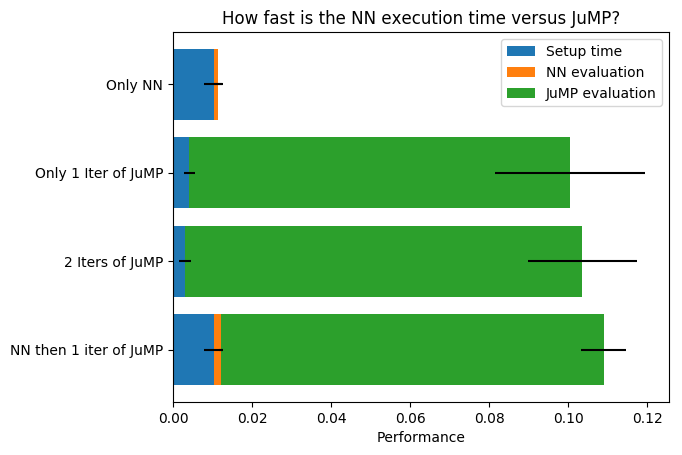

In [6]:
using PyPlot
plt.rcdefaults()
fig, ax = plt.subplots()

cases = ["Only NN", "Only 1 Iter of JuMP", "2 Iters of JuMP", "NN then 1 iter of JuMP"]
y_pos = collect(1:size(cases,1))
# setup_times = [0.010304352; 0.000680142; 0.000816981; 0.010304352]
# eval_NN_times = [0.005939701; 0.0; 0.0; 0.008162978]
# eval_gusto_times = [0.0; 0.078279717; 0.113373914; 0.09058192]

zerror = zeros(size(cases,1))

p1 = plt.barh(y_pos, setup_times, xerr=setup_error, align="center")
p2 = plt.barh(y_pos, eval_NN_times, xerr=eval_NN_error, align="center", left=setup_times)
p3 = plt.barh(y_pos, eval_gusto_times,  xerr=eval_gusto_error, align="center", left=eval_NN_times+setup_times)
ax.set_yticks(y_pos)
ax.set_yticklabels(cases)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Performance")
ax.set_title("How fast is the NN execution time versus JuMP?")
plt.legend(("Setup time","NN evaluation","JuMP evaluation"))
plt.show()

# No obstacle environment

In [3]:
function setUpEnvironmentNoObstacle()
    env = Table(:stanford);
    return env
end

setUpEnvironmentNoObstacle (generic function with 1 method)

# Single obstacle environment

In [4]:
function setUpEnvironmentSingleObstacle(xObs = 1.500, yObs = 1.500, width = 0.27)
    env = Table(:stanford);
    centers = Vector()
    push!(centers, [xObs; yObs; 0.0])

    widths = [width; width; 0.127]
    inflation = 0.05*ones(3)

    for idx in 1:length(centers)
        push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
    end
    return env
end

setUpEnvironmentSingleObstacle (generic function with 4 methods)

# Two obstacle environment

In [5]:
function setUpEnvironmentTwoObstacle(xObs1 = 1.500, yObs1 = 1.500, xObs2 = 1.00, yObs2 = 2.000, width = 0.10)
    env = Table(:stanford);
    centers = Vector()
    push!(centers, [xObs1; yObs1; 0.0])
    push!(centers, [xObs2; yObs2; 0.0])
    widths = [width; width; 0.127]
    inflation = 0.05*ones(3)

    for idx in 1:length(centers)
        push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
    end
    return env
end

setUpEnvironmentTwoObstacle (generic function with 6 methods)

# One obstacle environment

In [6]:
function setUpEnvironmentOneObstacle(xObs1 = 1.500, yObs1 = 1.500, width = 0.10)
    env = Table(:stanford);
    centers = Vector()
    push!(centers, [xObs1; yObs1; 0.0])
    widths = [width; width; 0.127]
    inflation = 0.05*ones(3)

    for idx in 1:length(centers)
        push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
    end
    return env
end

setUpEnvironmentOneObstacle (generic function with 4 methods)

# Multiple obstacle environment

In [7]:
function setUpEnvironment()
    env = Table(:stanford);
    centers = Vector()
    push!(centers, [0.460; 0.315; 0.0])
    push!(centers, [0.201; 1.085; 0.0])
    push!(centers, [0.540; 2.020; 0.0])
    push!(centers, [1.374; 0.196; 0.0])
    push!(centers, [1.063; 1.354; 0.0])
    push!(centers, [1.365; 2.322; 0.0])
    push!(centers, [2.221; 0.548; 0.0])
    push!(centers, [2.077; 1.443; 0.0])
    push!(centers, [3.098; 1.186; 0.0])
    push!(centers, [2.837; 2.064; 0.0])
    # push!(centers, [1.500; 1.500; 0.0])

    widths = [0.27; 0.27; 0.127]
    inflation = 0.05*ones(3)

    for idx in 1:length(centers)
        push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
    end
    return env
end

setUpEnvironment (generic function with 1 method)

# Create obstacle grid representation using centers, widths, and inflation
TODO

# Full set up model

In [8]:
function setUpProblemAllParams(N, x_init, x_goal, robot, model, env;tf_guess = 200.)
    goal_set = GoalSet()
    add_goal!(goal_set, Goal(PointGoal(x_goal), tf_guess, model))
    PD = ProblemDefinition(robot, model, env, x_init, goal_set)
    TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
    TOSgusto = TrajectoryOptimizationSolution(TOP)
    return TOP, TOSgusto
end

setUpProblemAllParams (generic function with 1 method)

# Set up problem, initial goal and final goal

In [9]:
function setUpProblem(N, x_init, x_goal;tf_guess = 200.)
    goal_set = GoalSet()
    add_goal!(goal_set, Goal(PointGoal(x_goal), tf_guess, model))
    PD = ProblemDefinition(robot, model, env, x_init, goal_set)
    TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
    TOSgusto = TrajectoryOptimizationSolution(TOP)
    return TOP, TOSgusto
end


setUpProblem (generic function with 1 method)

# Create GIF of XY trajectories

In [10]:
function plotGifOfXYTrajectories(X_vec)
    n_iter = size(X_vec,1)
    anim = @animate for i=1:n_iter
        X = X_vec[i]
        plot([X[1,:]],[X[2,:]],
        xlabel = "x",
        ylabel = "y",
        legend = :none)
#         plotSingleXYTrajectory(X_vec[i])
    end
    gif(anim, "/anim_fps15.gif", fps = 15)
    
    
#     @gif for i=1:n_iter
#         plotSingleXYTrajectory(X_vec[i])
#     end every 1
end
plotXYTrajectories(traj_X_vec)


UndefVarError: UndefVarError: plotXYTrajectories not defined

# Plot all trajectory iterations on one plot

In [64]:
function plotXYTrajectories(X_vec)
    n_iter = size(X_vec,1)
    gr(fmt=:png)
    plot()
    for i=1:n_iter
        X = X_vec[i]
        if i==1
            scatter!([X[1,1]],[X[2,1]],label="start point", marker=8)
            scatter!([X[1,end]],[X[2,end]],label="goal point", marker=8)
        end
        if i == n_iter || i==1
            plot!([X[1,:]],[X[2,:]],
            xlabel = "x",
            ylabel = "y",
            label = "iteration $i",
            title = "XY trajectory",
            linewidth = 5)
        else
            plot!([X[1,:]],[X[2,:]],
            xlabel = "x",
            ylabel = "y",
            label = "iteration $i",
            title = "XY trajectory")
        end
    end
    plot!()
end


plotXYTrajectories (generic function with 1 method)

# Plot all velocity trajectories on one plot

In [67]:
function plotVelocities(X_vec)
    n_iter = size(X_vec,1)
    gr(fmt=:png)
    plot()
    for i=1:n_iter
        X = X_vec[i]
        N = size(X,2)
        if i == n_iter || i==1
            plot!([collect(1:N)],[sqrt.(X[4,:].^2 + X[5,:].^2)],
            xlabel = "t",
            ylabel = "v",
            label = "iteration $i", 
            title = "velocity evolution",
            legend = :topleft,
            linewidth = 5)
        else
            plot!([collect(1:N)],[sqrt.(X[4,:].^2 + X[5,:].^2)],
            xlabel = "t",
            ylabel = "v",
            label = "iteration $i", 
            title = "velocity evolution",
            legend = :topleft)
        end
    end
    plot!()
end


plotVelocities (generic function with 1 method)

# Plot single XY trajectory

In [13]:
function plotSingleXYTrajectory(X)
    gr(fmt=:png)
    plot()
    plot!([X[1,:]],[X[2,:]],
        xlabel = "x",
        ylabel = "y",
        legend = :none)
    plot!()
end

plotSingleXYTrajectory (generic function with 1 method)

# Plot velocity along a trajectory

In [14]:
function plotVelocity(X, N)
    gr(fmt=:png)
    plot()
    plot!([collect(1:N)],[sqrt.(X[4,:].^2 + X[5,:].^2)],
        xlabel = "t",
        ylabel = "v",
        legend = :none)
    plot!()
end

plotVelocity (generic function with 1 method)

# Code for animating free-flyer trajectories

In [15]:
function visualizeTraj(env, TOSgusto)
    vis = Visualizer()
    delete!(vis)

    vis[:goal]
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3(x_goal[1:2]..., robot.r), 0.1),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

    vis[:table]
    table_dim = env.worldAABBmax-env.worldAABBmin
    setobject!(vis[:table][:table], 
            Object(HyperRectangle(env.worldAABBmin..., table_dim...),
                MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

    vis[:obstacles]
    for (idx,obs) in enumerate(env.obstacle_set)
        setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
            Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,0.3))))
    end

    vis[:robot]

    setobject!(vis[:robot][:base],
        Object(Cylinder(Point3f0(0,0,0.),Point3f0(0.,0.,0.5),Float32(robot.r)),MeshBasicMaterial(color=RGBA(0,0.,1.,0.7))))

    up = [0;0;1.]
    q0 = vec2quat(up,x_init[3])
    Qs = Vector{Vector{Float64}}()

    speed_factor = 10

    for k in 1:speed_factor:N
        q = [quat_inv(quat_multiply(mrp2quat([0.; 0.; tan(TOSgusto.SCPS.traj.X[3,k]/4)]), q0)); [TOSgusto.SCPS.traj.X[1:2,k]; robot.r]]
        push!(Qs,q)
    end

    anim = MeshCat.Animation()
    for k in 1:N
        atframe(anim, vis, 5*k) do frame
            settransform!(frame[:robot], Translation(TOSgusto.traj.X[1,k], 
                TOSgusto.traj.X[2,k], TOSgusto.traj.X[3,k]))
        end
    end
    setanimation!(vis, anim)

    # plot_in_cell = true
    plot_in_cell = false
    plot_in_cell ? IJuliaCell(vis) : open(vis)
end

visualizeTraj (generic function with 1 method)

# Get parameters for data like xMin, xRange, etc. from HDF5 file

In [16]:
function getDataParamsFromHDF5(filename)
    f = h5open(filename,"r")
    xMin = read(f["xMin"])
    yMin = read(f["yMin"])
    xRange = read(f["xRange"])
    yRange = read(f["yRange"])
    close(f)
    return xMin, yMin, xRange, yRange 
end


getDataParamsFromHDF5 (generic function with 1 method)

# Create input to neural network from X, U, ω, Δ, dual

In [17]:
function createNNInput(traj_X_vec, traj_U_vec, ω, Δ, xMin, xRange, dual = nothing)
    X_row = traj_X_vec[:]'
    U_row = traj_U_vec[:]'
    if dual == nothing
        NN_input = hcat(X_row, U_row, ω, Δ)'
    else
        NN_input = hcat(X_row, U_row, ω, Δ, dual')'
    end
    NN_input = (NN_input-xMin)./xRange
    return NN_input
    
end

createNNInput (generic function with 2 methods)

# Recover duals from neural network output and input

In [18]:
function recoverDualfromNNOutput(NN_output, yMin, yRange)
    output_Dual = (NN_output.*yRange)+yMin    
    return output_Dual
end

recoverDualfromNNOutput (generic function with 1 method)

# Recover X,U from neural network output and input

In [19]:
function recoverXUfromNNOutput(NN_output_diff, NN_input, xMin, xRange, yMin, yRange)
    input_true = (NN_input.*xRange)+xMin
    output_diff_true = (NN_output_diff.*yRange)+yMin
    output_true = input_true[1:180] + output_diff_true
    output_X = reshape(output_true[1:120], 6, 20)
    output_U = reshape(output_true[121:180], 3, 20)
    
    return (output_X, output_U)
end

recoverXUfromNNOutput (generic function with 1 method)

# Create Training data from X,U trajectories and trust region values

In [20]:
function createTrainingInputAndOutput(traj_X_vec, traj_U_vec, ω_vec, Δ_vec, dual_vec = nothing)
    X_row = hcat((map(a -> a[:], traj_X_vec))...)'
    U_row = hcat((map(a -> a[:], traj_U_vec))...)'
    if dual_vec != nothing
        dual_row = hcat((map(a -> a[:], dual_vec))...)'
    end
#     @show(size(ω_vec))
#     @show(size(X_row))
    if dual_vec == nothing
        train_input = hcat(X_row, U_row, ω_vec, Δ_vec)[1:end-1,:]
    else
        train_input = hcat(X_row, U_row, ω_vec, Δ_vec, dual_row)[1:end-1,:]
    end

    diff_X = traj_X_vec[2:end]-traj_X_vec[1:end-1]
    diff_U = traj_U_vec[2:end]-traj_U_vec[1:end-1]
    diff_X_row = hcat((map(a -> a[:], diff_X))...)'
    diff_U_row = hcat((map(a -> a[:], diff_U))...)'

    if dual_vec == nothing
        train_output = hcat(diff_X_row, diff_U_row)
    else
        train_output = hcat(diff_X_row, diff_U_row, dual_row[2:end, :])
    end
    
    if size(train_input,1) != size(train_output,1)
        println("ERROR: train input and output have different # of rows")
    end
    if size(train_input,2) - 2 != size(train_output,2)
        println("ERROR: each row of train input should 2 elements more than output")
    end
    
    return train_input, train_output
    
end

createTrainingInputAndOutput (generic function with 2 methods)

# Verify training input and output creation


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

size(traj_X_vec) = (2,)
size(traj_X_vec[1]) = (6, 20)


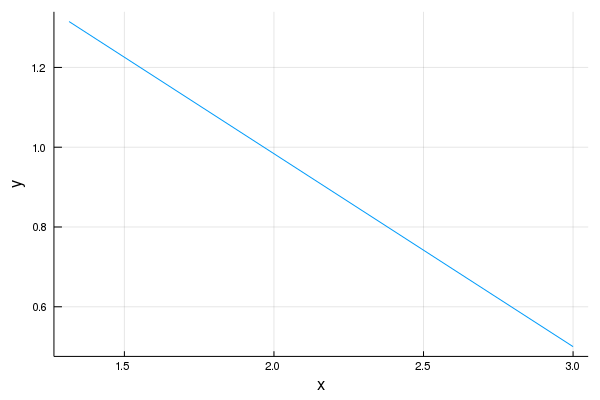

In [20]:
env = setUpEnvironmentSingleObstacle()
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
N = 20
x_init = [xObs; yObs; 0; 0; 0; 0] # starting inside the obstacle- infeasible
x_goal = [3.; 0.5; 0; 0; 0; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=80);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
@show size(traj_X_vec)
@show size(traj_X_vec[1])
one_X_traj = traj_X_vec[1]
gr(fmt=:png)
plot()
plot!([one_X_traj[1,:]],[one_X_traj[2,:]],
    xlabel = "x",
    ylabel = "y",
    legend = :none)
plot!()


# train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
# @show size(train_input)
# xvals = train_input[1,1:20]
# @show size(xvals)
# yvals = train_input[1,21:40]
# @show size(yvals)
# gr(fmt=:png)
# plot()
# plot!([xvals],[yvals],
#     xlabel = "x",
#     ylabel = "y",
#     legend = :none)
# plot!()

# Recover goal and start points from training data

In [21]:
function recoverProblemConditionsFromTrainInput(train_input) 
    recover_x_init_from_train = train_input[1,1:6]
    @show recover_x_init_from_train
    recover_x_goal_from_train = train_input[1,(6*N-5):(6*N + 1)]
    @show recover_x_goal_from_train
    # NOTE that size(train_input,2)-2 = x_dim * N
end
function recoverProblemConditionsFromTrajVec(traj_X_vec) 
    recover_x_init = traj_X_vec[1][:,1]
    @show recover_x_init
    recover_x_goal = traj_X_vec[1][:,end]
    @show recover_x_goal
    # NOTE that size(traj_X_vec[1]) = (x_dim * N)
end

recoverProblemConditionsFromTrajVec (generic function with 1 method)

# Plot trajectory if starting from within obstacle (infeasible start point)

In [22]:
env = setUpEnvironmentSingleObstacle()
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
N = 20
x_init = [xObs; yObs; 0; 0; 0; 0] # starting inside the obstacle- infeasible
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=200);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.converged
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.converged
# Conclusion: if the scp_status never changes to OK, we probably shouldn't store this set of trajectories
# This basically means that GuSTO converged (SCPS.converged) and is "locally solved" (SCPS.solver_status) but never finds an "OK" solution (SCPS.scp_status)

(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED]
(TOSgusto.SCPS).accept_solution = Bool[true, true]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 10.0]
(TOSgusto.SCPS).converged = false
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
iterCount = 7
iterCount = 8
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, ITERATION_LIMIT]
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true, true, true]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0, 1

false

# Plot trajectories from GuSTO for no obstacles

## tf = 200 s

In [66]:
env = setUpEnvironmentNoObstacle()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=200);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3
iterCount = 4


(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :OK, :OK, :OK]


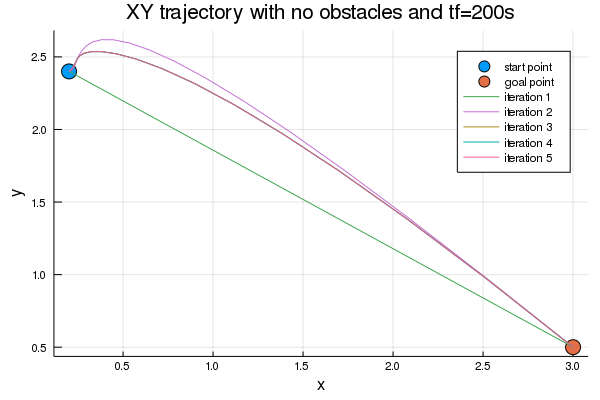

In [67]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with no obstacles and tf=200s")


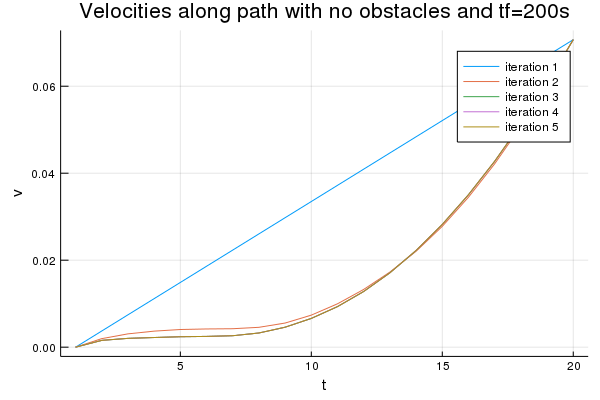

In [17]:
plotVelocities(traj_X_vec)
title!("Velocities along path with no obstacles and tf=200s")

## tf = 50 s

In [39]:
env = setUpEnvironmentNoObstacle()
N = 20
x_init = [2.0; 1.1; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=50);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3


(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :OK, :OK]


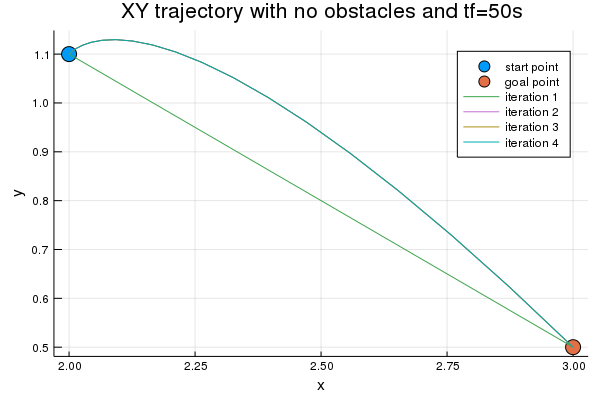

In [40]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with no obstacles and tf=50s")

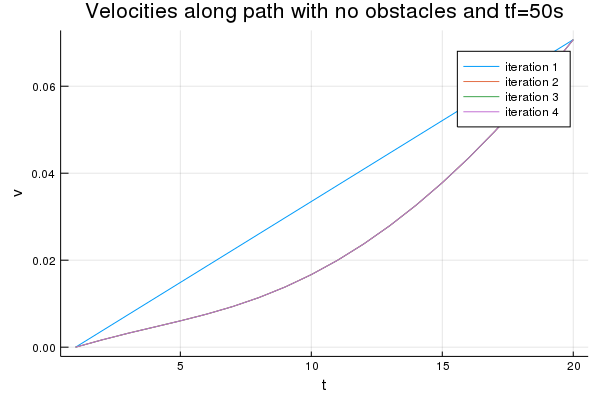

In [41]:
plotVelocities(traj_X_vec)
title!("Velocities along path with no obstacles and tf=50s")

## tf = 400 s

In [23]:
env = setUpEnvironmentNoObstacle()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=400);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5


(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :ViolatesConstraints, :OK, :OK, :OK]


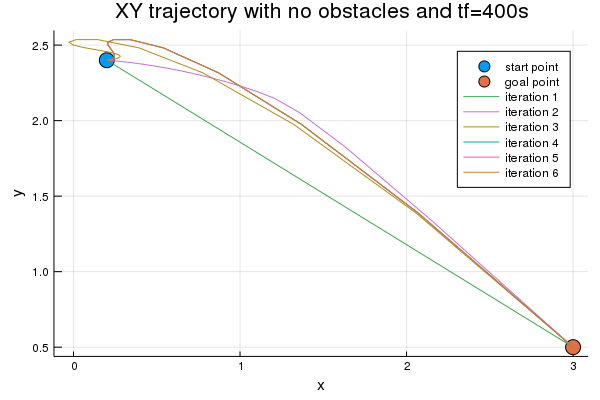

In [24]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec)
title!("XY trajectory with no obstacles and tf=400s")

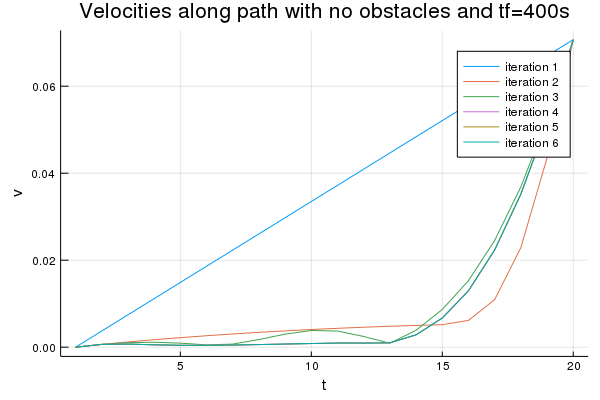

In [25]:
plotVelocities(traj_X_vec)
title!("Velocities along path with no obstacles and tf=400s")

# Plot trajectories from GuSTO for ONE obstacle

## tf = 200s

In [49]:
xObs = 1.500; yObs = 1.500; width = 0.1
env = setUpEnvironmentSingleObstacle(xObs, yObs, width)
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess=200);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
max_iter = 30
while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5
iterCount = 6
iterCount = 7
iterCount = 8
iterCount = 9
iterCount = 10
iterCount = 11
iterCount = 12
iterCount = 13
iterCount = 14
iterCount = 15
iterCount = 16
iterCount = 17
iterCount = 18
iterCount = 19
iterCount = 20
iterCount = 21
iterCount = 22
iterCount = 23
iterCount = 24
iterCount = 25
iterCount = 26
iterCount = 27
iterCount = 28
iterCount = 29
iterCount = 30
iterCount = 31


(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :ViolatesConstraints, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK, :OK]


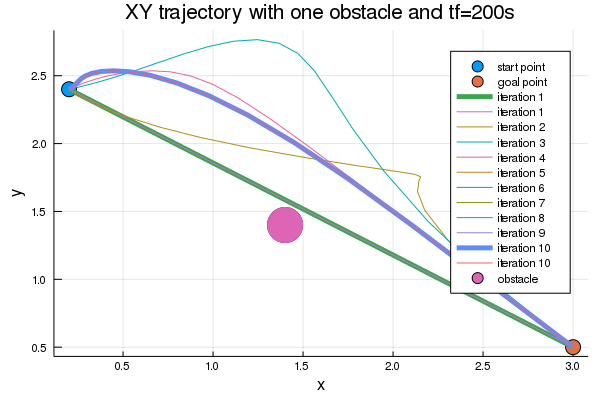

In [53]:
@show TOSgusto.SCPS.scp_status
plotXYTrajectories(traj_X_vec[1:10])
title!("XY trajectory with one obstacle and tf=200s")
xObs = env.obstacle_set[1].origin[1]
yObs = env.obstacle_set[1].origin[2]
widthObs = env.obstacle_set[1].widths[1]
scatter!([xObs],[yObs],markersize=100*widthObs, label="obstacle")


In [28]:
@show env.obstacle_set[1].origin
@show env.obstacle_set[1].widths


(env.obstacle_set[1]).origin = Float32[1.4, 1.4, -0.0635]
(env.obstacle_set[1]).widths = Float32[0.2, 0.2, 0.227]


3-element Vec{3,Float32}:
 0.2  
 0.2  
 0.227

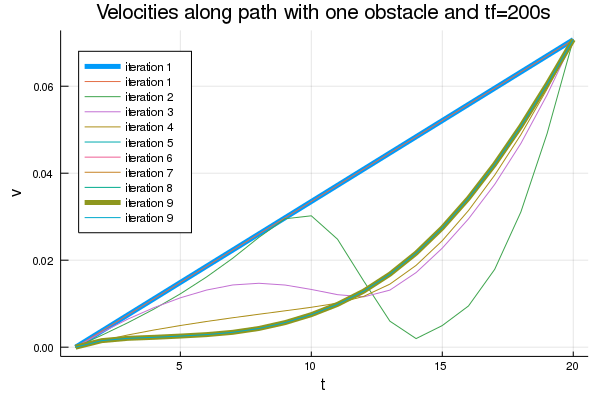

In [59]:
plotVelocities(traj_X_vec[1:9])
title!("Velocities along path with one obstacle and tf=200s")


In [30]:
            @show TOSgusto.SCPS.scp_status
            @show TOSgusto.SCPS.solver_status
            @show TOSgusto.SCPS.accept_solution
            @show TOSgusto.SCPS.param.alg.ω_vec

(TOSgusto.SCPS).scp_status = Symbol[:NA, :OK, :ViolatesConstraints, :OK, :OK, :OK, :OK]
(TOSgusto.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED]
(TOSgusto.SCPS).accept_solution = Bool[true, true, true, true, true, true, true]
(((TOSgusto.SCPS).param).alg).ω_vec = [1.0, 1.0, 10.0, 10.0, 10.0, 10.0, 10.0]


7-element Array{Float64,1}:
  1.0
  1.0
 10.0
 10.0
 10.0
 10.0
 10.0

# Ending with zero velocity or very small velocity results in no change to trajectory

iterCount = 2
iterCount = 3
Saving data solution converged and is OK


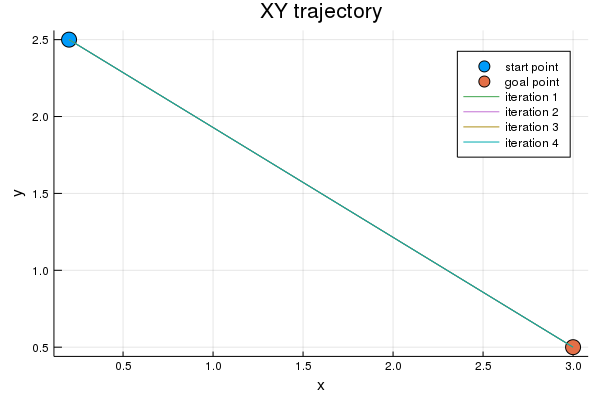

In [34]:
# ZERO VELOCITY
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
x_init = [0.2; 2.5; 0; 0; 0; 0] 
TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]

# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1

while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
#             @show TOSgusto.SCPS.solver_status[end]
    if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = iterCount + 1
        @show iterCount
    end
end
if TOSgusto.SCPS.scp_status[end] == :OK 
    if TOSgusto.SCPS.converged
        println("Saving data solution converged and is OK")
    else
        println("solution is ok but DID NOT converge")
    end
else
    @show TOSgusto.SCPS.scp_status
    println("solution DID NOT end in OK")
    if TOSgusto.SCPS.converged
        println("solution converged")
    else
        println("solution DID NOT converge")
    end
end
plotXYTrajectories(traj_X_vec)


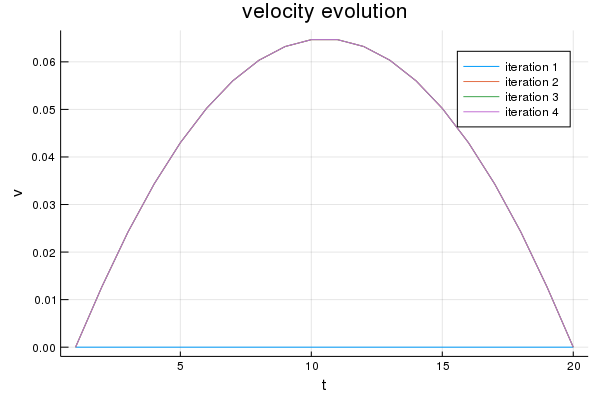

In [35]:
plotVelocities(traj_X_vec)


# Time/benchmark GuSTO

In [14]:
# change default for `seconds` to 1
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1.0
# change default for `samples` to 10
BenchmarkTools.DEFAULT_PARAMETERS.samples = 3

# Examples of how to time:
# t = @elapsed env = setUpEnvironmentNoObstacle() 

# myenv = @btime setUpEnvironmentNoObstacle()
# @show myenv

# nenv = setUpEnvironmentNoObstacle() 
# tm = @belapsed nenv = setUpEnvironmentNoObstacle() 
# @show tm
# @show nenv

3

In [15]:
# Run everything once just to get things compiled and ready for timing

firstFullTime = @elapsed begin
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 10
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 2

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
xVal = xVals[1]
yVal = yVals[1]
x_init = [xVal; yVal; 0; 0; 0; 0] 
firstSetupTime = @elapsed TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
firstSolveTime = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1
firstCreateTrainingTime = @elapsed train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
end

@show firstSetupTime
@show firstSolveTime
@show firstCreateTrainingTime
@show firstFullTime


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

firstSetupTime = 5.002713315
firstSolveTime = 38.92497795
firstCreateTrainingTime = 1.182570358
firstFullTime = 46.972194743


46.972194743

In [21]:
# Time these

setupTimes = []
solveTimes = []
problemTimes = []

env = setUpEnvironmentNoObstacle()

N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 10
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)

max_iter = 2

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        problemTime = @elapsed begin 
        x_init = [xVal; yVal; 0; 0; 0; 0] 
        
        setupTime = @elapsed TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        push!(setupTimes, setupTime)
            
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        traj_U_vec_first_only = [traj_init.U]
        # Solve one step at a time with IPOPT
        solveTime = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(solveTimes, solveTime)
            
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solveTime = @elapsed solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
            push!(solveTimes, solveTime)
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
#             @show TOSgusto.SCPS.solver_status[end]
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
#                 @show iterCount
            end
        end
#         if TOSgusto.SCPS.scp_status[end] == :OK 
#             if TOSgusto.SCPS.converged
#                 println("Saving data solution converged and is OK")
#                 train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
#                 train_input_first_only, train_output_first_only = createTrainingInputAndOutput(traj_X_vec_first_only, traj_U_vec_first_only, TOSgusto.SCPS.param.alg.ω_vec[1:2], TOSgusto.SCPS.param.alg.Δ_vec[1:2])
#         #         @show size(train_input)
#         #         @show size(train_output)
#                 train_input_collected = vcat(train_input_collected, train_input)
#                 train_output_collected = vcat(train_output_collected, train_output)
#                 train_input_collected_first_only = vcat(train_input_collected_first_only, train_input_first_only)
#                 train_output_collected_first_only = vcat(train_output_collected_first_only, train_output_first_only)
#             else
#                 println("solution is ok but DID NOT converge")
#             end
#         else
#             @show TOSgusto.SCPS.scp_status
#             println("solution DID NOT end in OK")
#             if TOSgusto.SCPS.converged
#                 println("solution converged")
#             else
#                 println("solution DID NOT converge")
#             end
#         end
        end
        push!(problemTimes, problemTime)
        problemNumber = problemNumber + 1
    end
end

meanSolveTime = mean(solveTimes)
meanProblemTime = mean(problemTimes)
meanNumberOfSolverPerProblem = length(solveTimes)/length(problemTimes)
println("")
println("Mean solve time for solve_SCP!: $meanSolveTime")
println("Mean number of solves per problem: $meanNumberOfSolverPerProblem")
println("Mean problem time: $meanProblemTime")



problemNumber = 1

problemNumber = 2

problemNumber = 3

problemNumber = 4

problemNumber = 5

problemNumber = 6

problemNumber = 7

problemNumber = 8

problemNumber = 9

Mean solve time for solve_SCP!: 0.05211993377777776
Mean number of solves per problem: 3.0
Mean problem time: 0.159812594


# Now train on SINGLE obstacle environments, keep only first 3 iterations, check that final solution in 3 iterations is OK and converges, with Thomas's suggestions

In [17]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentSingleObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 2

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
#             @show TOSgusto.SCPS.solver_status[end]
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        if TOSgusto.SCPS.scp_status[end] == :OK 
            if TOSgusto.SCPS.converged
                println("Saving data solution converged and is OK")
                train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
        #         @show size(train_input)
        #         @show size(train_output)
                train_input_collected = vcat(train_input_collected, train_input)
                train_output_collected = vcat(train_output_collected, train_output)
            else
                println("solution is ok but DID NOT converge")
            end
        else
            @show TOSgusto.SCPS.scp_status
            println("solution DID NOT end in OK")
            if TOSgusto.SCPS.converged
                println("solution converged")
            else
                println("solution DID NOT converge")
            end
        end

        problemNumber = problemNumber + 1
        @save "SingleObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2" train_input_collected train_output_collected
    end
end


problemNumber = 1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 2
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 3
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 4
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 5
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 6
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 7
iterCount = 2
iterCount = 3
Saving data solution converged and is


problemNumber = 69
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 70
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 71
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 72
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 73
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 74
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 75
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 76
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 77
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 78
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 79
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 80
iterCount = 2
iterCount = 


problemNumber = 141
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 142
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 143
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 144
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 145
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 146
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 147
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 148
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 149
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 150
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstrain


problemNumber = 213
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 214
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 215
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 216
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 217
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution

iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 281
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 282
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 283
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 284
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 285
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 286
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 287
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 288
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 289
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 290
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 291
iterCount = 2
iterCount = 3
solutio


problemNumber = 356
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 357
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 358
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 359
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 360
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 361
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 362
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 363
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 364
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 365
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 366
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesCo


problemNumber = 415
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 416
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 417
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 418
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 419
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 420
iterCount = 2
iterCount = 3
solution is ok but DID NOT con

iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 471
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 472
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 473
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 474
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 475
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :Viol


problemNumber = 524
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 525
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 526
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 527
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 528
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 529
iterCount = 2
iterCount = 3
Saving data solution conv


problemNumber = 575
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 576
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 577
iterCount = 2
iterCount = 3
solution is ok but DID NOT converge

problemNumber = 578
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 579
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 580
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 581
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 582
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 583
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 584
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :Vi


problemNumber = 630
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 631
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 632
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 633
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 634
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution


problemNumber = 683
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 684
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 685
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 686
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 687
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 688
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 689
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 690
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 691
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 692
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 693
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNu


problemNumber = 756
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 757
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 758
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 759
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 760
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 761
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 762
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 763
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 764
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 765
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 766
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNu


problemNumber = 829
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 830
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 831
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution converged

problemNumber = 832
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 833
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 834
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT 


problemNumber = 897
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 898
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 899
iterCount = 2
iterCount = 3
(TOSgusto.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
solution DID NOT end in OK
solution DID NOT converge

problemNumber = 900
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 901
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 902
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumber = 903
iterCount = 2
iterCount = 3
Saving data solution converged and is OK

problemNumbe

# Only train on no obstacle environments, keep only first 3 iterations, check that final solution in 3 iterations is OK and converges, with Thomas's suggestions, also store 1st iteration separately


problemNumber = 1
iterCount = 2
iterCount = 3
Saving data solution converged and is OK


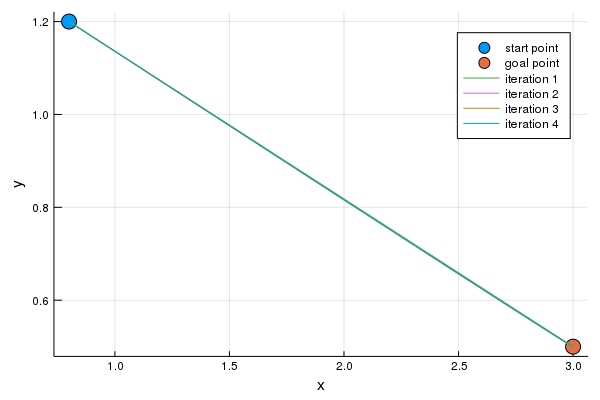

In [28]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0; 0; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 2

train_input_collected_first_only = Array{Float64}(undef,0,182)
train_output_collected_first_only = Array{Float64}(undef,0,180)

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 80);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        traj_X_vec_first_only = [traj_init.X]
        traj_U_vec_first_only = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        push!(traj_X_vec_first_only, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec_first_only, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
#             @show TOSgusto.SCPS.solver_status[end]
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED 
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        if TOSgusto.SCPS.scp_status[end] == :OK 
            if TOSgusto.SCPS.converged
                println("Saving data solution converged and is OK")
                train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
                train_input_first_only, train_output_first_only = createTrainingInputAndOutput(traj_X_vec_first_only, traj_U_vec_first_only, TOSgusto.SCPS.param.alg.ω_vec[1:2], TOSgusto.SCPS.param.alg.Δ_vec[1:2])
        #         @show size(train_input)
        #         @show size(train_output)
                train_input_collected = vcat(train_input_collected, train_input)
                train_output_collected = vcat(train_output_collected, train_output)
                train_input_collected_first_only = vcat(train_input_collected_first_only, train_input_first_only)
                train_output_collected_first_only = vcat(train_output_collected_first_only, train_output_first_only)
            else
                println("solution is ok but DID NOT converge")
            end
        else
            @show TOSgusto.SCPS.scp_status
            println("solution DID NOT end in OK")
            if TOSgusto.SCPS.converged
                println("solution converged")
            else
                println("solution DID NOT converge")
            end
        end

        problemNumber = problemNumber + 1
        @save "NoObstacleFirst3IterEndsInOKtf80ZeroFinVel.jld2" train_input_collected train_output_collected
        @save "NoObstacleFirst3IterEndsInOKtf80ZeroFinVelOnly1Iter.jld2" train_input_collected_first_only train_output_collected_first_only
    end
end

# Only train on no obstacle environments and keep only first 2 iterations

In [34]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentNoObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 2

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 50);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        @show size(traj_X_vec)
        @show size(traj_X_vec[1])
        @show size(traj_U_vec[1])
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
        @show size(train_input)
        @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "NoObstacleFirst3Iter.jld2" train_input_collected train_output_collected
    end
end


problemNumber = 1
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 2
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 3
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 4
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
size(traj_X_vec[1]) = (6, 20)
size(traj_U_vec[1]) = (3, 20)
size(ω_vec) = (4,)
size(X_row) = (4, 120)
size(train_input) = (3, 182)
size(train_output) = (3, 180)

problemNumber = 5
iterCount = 2
iterCount = 3
size(traj_X_vec) = (4,)
s

InterruptException: InterruptException:

# Only train on single obstacle environments and keep only first 4 iterations

In [ ]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironmentSingleObstacle()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 4

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal, tf_guess = 50);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
#         @show size(train_input)
#         @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "SingleObstacleFirst5Iter.jld2" train_input_collected train_output_collected
    end
end


problemNumber = 1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

iterCount = 2
iterCount = 3

problemNumber = 2
iterCount = 2
iterCount = 3

problemNumber = 3
iterCount = 2
iterCount = 3

problemNumber = 4
iterCount = 2
iterCount = 3

problemNumber = 5
iterCount = 2
iterCount = 3

problemNumber = 6
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 7
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 8
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 9
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 10
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 11
iterCount = 2
iterCount = 3
iterCount = 4

problemN

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 117
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 118
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 119
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 120
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 121
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 122
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 123
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 124
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 125
iterCount = 2
iterCount = 3

problemNumber = 126
iterCount = 2
iterCount = 3

problemNumber = 127
iterCount = 2
iterCount = 3

problemNumber = 128
iterCount = 2
iterCount = 3

problemNumber = 129
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 130
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 131

iterCount = 4
iterCount = 5

problemNumber = 234
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 235
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 236
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 237
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 238
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 239
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 240
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 241
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 242
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 243
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 244
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 245
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 246
iterCount = 2
iterCount = 3
iterCount = 4

iterCount = 4

problemNumber = 349
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 350
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 351
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 352
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 353
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 354
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 355
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 356
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 357
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 358
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 359
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 360
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 361
iterCount = 2
iterCount = 3
iterCount = 4

iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 462
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 463
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 464
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 465
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 466
iterCount = 2
iterCount = 3

problemNumber = 467
iterCount = 2
iterCount = 3

problemNumber = 468
iterCount = 2
iterCount = 3

problemNumber = 469
iterCount = 2
iterCount = 3

problemNumber = 470
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 471
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 472
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 473
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 474
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 475
iterCount = 2
iterCount = 3
iterCount = 4
iterCo

iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 578
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 579
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 580
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 581
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 582
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 583
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 584
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 585
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 586
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 587
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 588
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 589
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 590
iterCount = 2
iterCount = 3

problemNumber = 591
iterCount = 2
iterCount = 3

problemNumber = 592

iterCount = 3
iterCount = 4

problemNumber = 708
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 709
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 710
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 711
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 712
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 713
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 714
iterCount = 2
iterCount = 3

problemNumber = 715
iterCount = 2
iterCount = 3

problemNumber = 716
iterCount = 2
iterCount = 3

problemNumber = 717
iterCount = 2
iterCount = 3

problemNumber = 718
iterCount = 2
iterCount = 3

problemNumber = 719
iterCount = 2
iterCount = 3

problemNumber = 720
iterCount = 2
iterCount = 3

problemNumber = 721
iterCount = 2
iterCount = 3

problemNumber = 722
iterCount = 2
iterCount = 3

problemNumber = 723
iterCount = 2
iterCount = 3

problemNumber = 724


problemNumber = 859
iterCount = 2
iterCount = 3

problemNumber = 860
iterCount = 2
iterCount = 3

problemNumber = 861
iterCount = 2
iterCount = 3

problemNumber = 862
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 863
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 864
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 865
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 866
iterCount = 2
iterCount = 3
iterCount = 4
iterCount = 5

problemNumber = 867
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 868
iterCount = 2
iterCount = 3
iterCount = 4

problemNumber = 869
iterCount = 2
iterCount = 3

problemNumber = 870
iterCount = 2
iterCount = 3

problemNumber = 871
iterCount = 2
iterCount = 3

problemNumber = 872
iterCount = 2
iterCount = 3

problemNumber = 873
iterCount = 2
iterCount = 3

problemNumber = 874
iterCount = 2
iterCount = 3

problemNumber = 875
iterCount = 2
iterCount = 3

problemNumber = 876
iterCo

# Code for second batch of training data

In [ ]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironment()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 1000
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 30

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
#         @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#             @show TOSgusto.SCPS.scp_status
#             @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
#         @show size(train_input)
#         @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "secondBatch.jld2" train_input_collected train_output_collected
    end
end

# @save "firstBatch.jld2" train_input_collected train_output_collected


# Code for first batch of training data

In [ ]:
# Generate training data
# Keep environment constant and goal constant 
env = setUpEnvironment()
N = 20
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
num_problems = 100
numInEach = sqrt(num_problems)
xMin = 0.2
xMax = 2.5
yMin = 0.8 
yMax = 3.0
xVals = collect(xMin:(xMax-xMin)/floor(numInEach-1):xMax)
yVals = collect(yMin:(yMax-yMin)/floor(numInEach-1):yMax)
# @show xVals
# @show yVals

max_iter = 30

train_input_collected = Array{Float64}(undef,0,182)
train_output_collected = Array{Float64}(undef,0,180)

problemNumber = 1
for xVal in xVals
    for yVal in yVals
        println("")
        @show problemNumber
        x_init = [xVal; yVal; 0; 0; 0; 0] 
        @show x_init
        TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
        traj_init = init_traj_straightline(TOP)
        traj_X_vec = [traj_init.X]
        traj_U_vec = [traj_init.U]
        # Solve one step at a time with IPOPT
        solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
        push!(traj_X_vec, TOSgusto.SCPS.traj.X)
        push!(traj_U_vec, TOSgusto.SCPS.traj.U)
        iterCount = 1
        
        while !TOSgusto.SCPS.converged && iterCount <=max_iter && (TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED)
            solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
            @show TOSgusto.SCPS.scp_status
            @show TOSgusto.SCPS.solver_status
#             @show TOSgusto.SCPS.accept_solution
#             @show TOSgusto.SCPS.param.alg.ω_vec
            if TOSgusto.SCPS.solver_status[end] == MOI.LOCALLY_SOLVED
                push!(traj_X_vec, TOSgusto.SCPS.traj.X)
                push!(traj_U_vec, TOSgusto.SCPS.traj.U)
                iterCount = iterCount + 1
                @show iterCount
            end
        end
        train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
        @show size(train_input)
        @show size(train_output)
        train_input_collected = vcat(train_input_collected, train_input)
        train_output_collected = vcat(train_output_collected, train_output)
        problemNumber = problemNumber + 1
        @save "firstBatch.jld2" train_input_collected train_output_collected
    end
end

# @save "firstBatch.jld2" train_input_collected train_output_collected


In [ ]:
# Violates constraints start point
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# Solve full solution with IPOPT
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0);


In [ ]:
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

In [ ]:
# Violates constraints start point
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);

traj_init = init_traj_straightline(TOP)
traj_X_vec = [traj_init.X]
traj_U_vec = [traj_init.U]
# Solve one step at a time with IPOPT
solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj_init, "Ipopt", max_iter=1, print_level=0);
push!(traj_X_vec, TOSgusto.SCPS.traj.X)
push!(traj_U_vec, TOSgusto.SCPS.traj.U)
iterCount = 1

while !TOSgusto.SCPS.converged && iterCount <=50
    solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    push!(traj_X_vec, TOSgusto.SCPS.traj.X)
    push!(traj_U_vec, TOSgusto.SCPS.traj.U)
    iterCount = iterCount + 1
    @show iterCount 
#     @show TOSgusto.SCPS.param.alg.ω_vec
#     @show TOSgusto.SCPS.param.alg.Δ_vec
end
println("Finished!")
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show size(traj_X_vec)



In [ ]:
train_input, train_output = createTrainingInputAndOutput(traj_X_vec, traj_U_vec, TOSgusto.SCPS.param.alg.ω_vec, TOSgusto.SCPS.param.alg.Δ_vec)
@show size(train_input)
@show size(train_output)


In [ ]:
traj_X_vec_3d=cat(traj_X_vec...,dims=3)
@show size(traj_X_vec_3d)

using JLD2, FileIO
hello = "world"
foo = :bar
@save "example.jld2" hello foo

In [ ]:
# OK start point
env = setUpEnvironment()
N = 20
x_init = [0.2; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# Solve full solution with IPOPT
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=100, print_level=0);


In [ ]:
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

In [ ]:
plotVelocity(TOSgusto.SCPS.traj.X, N)
plotXYTrajectory(TOSgusto.SCPS.traj.X)

In [ ]:
visualizeTraj(env, TOSgusto)

In [ ]:
# Solve full solution with Gurobi
env = setUpEnvironment()
N = 20
x_init = [0.4; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", max_iter=100, OutputFlag=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.accept_solution
# visualizeTraj(env, TOSgusto)

In [ ]:
# Create loop to run SCP one iteration at a time and store off TOSgusto.SCPS.traj as well as parameters
first_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations


# @show TOSgusto.SCPS.converged
# @show TOSgusto.SCPS.dual


In [ ]:
second_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations


In [ ]:
for i in 1:20
    next_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
    @show TOSgusto.SCPS.scp_status
    @show TOSgusto.SCPS.param.alg.ω_vec
    @show TOSgusto.SCPS.param.alg.Δ_vec
    @show TOSgusto.SCPS.traj.X
    @show TOSgusto.SCPS.traj.U
    @show TOSgusto.SCPS.traj.Tf
    @show TOSgusto.SCPS.traj.dt
    @show TOSgusto.SCPS.iterations
end

In [ ]:
full_SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=100, print_level=0);
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.traj.X
@show TOSgusto.SCPS.traj.U
@show TOSgusto.SCPS.traj.Tf
@show TOSgusto.SCPS.traj.dt
@show TOSgusto.SCPS.iterations

In [ ]:
include("../ok.jl")

In [ ]:
# @show TOSgusto.SCPS.param.alg.ω_vec
function ok()
    print("thiss2")
end
ok()

In [ ]:
SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
@show TOSgusto.SCPS.dual
@show TOSgusto.SCPS.traj
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec

In [ ]:
using Profile
using ProfileView 
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
Profile.clear()
@profile solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0)
ProfileView.view()

In [ ]:
using Profile
using ProfileView 
env = setUpEnvironment()
N = 20
x_init = [0.6; 2.4; 0; 0; 0; 0]
x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
Profile.clear()
@profile solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0)
ProfileView.view()

In [ ]:
SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Gurobi", OutputFlag=0);
# SCPS = solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0);


In [ ]:
@show TOSgusto.SCPS.converged
@show TOSgusto.SCPS.iterations
@show TOSgusto.SCPS.total_time
@show TOSgusto.SCPS.accept_solution
@show TOSgusto.SCPS.solver_status
@show TOSgusto.SCPS.scp_status
@show TOSgusto.SCPS.convergence_measure
@show TOSgusto.SCPS.param.alg.ω_vec
@show TOSgusto.SCPS.param.alg.Δ_vec
@show TOSgusto.SCPS.J_true
@show TOSgusto.SCPS.dual
;

In [ ]:
@show TOSgusto.SCPS.traj


In [ ]:
typeof(TOSgusto.SCPS.traj)


In [ ]:
# Old version of code
# # Violates constraints start point
# env = setUpEnvironment()
# N = 20
# x_init = [0.6; 2.4; 0; 0; 0; 0]
# x_goal = [3.; 0.5; 0; 0.05; -0.05; 0]
# TOP, TOSgusto = setUpProblem(N, x_init, x_goal);
# if isdefined(TOSgusto, :SCPS)
#     println("Before first, TOSgusto.SCPS defined")
# else
#     println("Before first, TOSgusto.SCPS NOT defined")
# end
# # Solve one step at a time with IPOPT
# solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", max_iter=1, print_level=0);
# # @show typeof(TOSgusto.SCPS.SCPP.param.alg)
# iterCount = 1
# if isdefined(TOSgusto.SCPS.param, :alg)
#     println("After first, TOSgusto.SCPS.param.alg defined")
# else
#     println("After first, TOSgusto.SCPS.param.alg NOT defined")
# end
# while !TOSgusto.SCPS.converged && iterCount <=15
#     solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, TOSgusto.SCPS.traj, "Ipopt", max_iter=1, print_level=0);
#     iterCount = iterCount + 1
#     @show iterCount 
#     @show TOSgusto.SCPS.param.alg.ω_vec
#     @show TOSgusto.SCPS.param.alg.Δ_vec
# end
# println("Finished!")
# @show TOSgusto.SCPS.scp_status
# @show TOSgusto.SCPS.iterations
# @show TOSgusto.SCPS.converged
# @show TOSgusto.SCPS.param.alg.ω_vec
# @show TOSgusto.SCPS.param.alg.Δ_vec